In [86]:
#What happens if the model is trained on 500 fake pdf using large model, each pdf is seen 2 times?

#Some people are good with numbers, others are good with running if, for loops, and loops within loops in their heads!

from transformers import LayoutLMv3Tokenizer,LayoutLMv3FeatureExtractor,LayoutLMv3ForTokenClassification,AutoModelForTokenClassification,AutoProcessor
import pandas as pd
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from PIL import Image, ImageDraw, Image, ImageFont, ImageColor, ImageOps
from sklearn.utils import shuffle
import random

In [87]:
feature_extractor = LayoutLMv3FeatureExtractor()
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

In [88]:
company = [163,92,1569,166]
job = [163,92,1569,166]
ssn =[174,226,1179,292]
resident = [266, 295, 1577, 355]
location = [353,361,1590,437]
blood_group = [298,421,400,495]
website = [226,495,1403,564]
username = [255, 561,1377, 617]
name = [189, 619, 1345, 685]
sex = [158, 690, 261, 762]
address = [224, 762, 944,851]
mail = [179, 833, 511, 888]
birthday = [234, 893, 443, 967]
description = [68, 1062, 1627,2307]

annotation_dict = {
    'job':job,
    'company':company,
    'ssn':ssn,
    'resident':resident,
    'location': location,
    'blood_group': blood_group,
    'website':website,
    'username':username,
    'name':name,
    'sex':sex,
    'address': address,
    'mail':mail,
    'birthday':birthday,
    'description':description
}


In [89]:
def generateonefakeppdf():
    from faker import Faker
    import warnings
    warnings.filterwarnings('ignore')
    from fpdf import FPDF
    import pdf2image
    fake = Faker()
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font('helvetica', size=12)
    profile = fake.profile()
    profile.keys()
    for k in profile.keys():
        try:
            pdf.cell(txt=' ',ln=1)
            pdf.cell(txt=f'{k.capitalize()}:')
            pdf.cell(txt= f' {profile[k]}',ln=1)
        except:
            pass
    pdf.cell(txt=' ',ln=1)
    pdf.cell(0, 10, 'Description', 0, 0, 'C')
    pdf.ln(10)
    pdf.cell(txt=' ',ln=1)
    pdf.cell(txt= fake.catch_phrase(),ln=1)
    pdf.cell(txt=' ',ln=1)
    for p in fake.paragraphs():
        pdf.multi_cell(align='l',txt=p,w=200,ln=1)
        pdf.cell(txt=' ',ln=1)

    pdf.output(f"fakepdf.pdf")
    image = pdf2image.convert_from_path('fakepdf.pdf')[0]
    return image 

In [148]:
def automatefakelabelling(label,words,boxes,hh,ww):
    X1,Y1,X2,Y2 = annotation_dict[label]
    W =[]
    B = []
    for w,b in zip(words,boxes):
        b_ = unnormalize_box(b,ww,hh)
        b_ = [int(a) for a in b_]
        x1,y1,x2,y2 = b_
        xx1 = min(X1, X2) - x1
        xx2 = max(X1, X2) - x2
        yy1 = min(Y1, Y2) - y1
        yy2 = max(Y1, Y2) - y2
        if xx1 <= 0 and yy1 <= 0 and xx2 >= 0 and yy2 >= 0:
            W.append(w)
            B.append(b)
    return W,B
        

In [170]:
labels = annotation_dict.keys()
label2dict = {}
dict2label = {}
for label, n in zip(labels, [i for i in range(len(labels))]):
    label2dict[label] = n
    dict2label[n] = label
    
dict2label[len(labels)] = 'other'
label2dict['other'] = len(labels)
def generatefakeimageandannotation(image):
    encoding = feature_extractor(image, return_tensors="pt")
    words = encoding['words'][0]
    boxes = encoding['boxes'][0]
    hh,ww = image.height,image.width
    W =[]
    B =[]
    L = []
    for k in annotation_dict.keys():
        w_,b_= automatefakelabelling(k,words,boxes,hh,ww)
        W.append(w_)
        B.append(b_)
        for k_ in [k for _ in range(len(w_))]:
            L.append(k)

    W_ = []
    B_ = []
    for w,b in zip(W,B):
        for ww,bb in zip(w,b):
            W_.append(ww)
            B_.append(bb)
    
    L = [label2dict[l] for l in L] 
    others = set(words).difference(set(W_))
    for o in others:
        for word,box in zip(words,boxes):
            if o == word:
                W_.append(o)
                B_.append(box)
                L.append(len(labels))
    return W_,B_,L,image

In [182]:
model = AutoModelForTokenClassification.from_pretrained("microsoft/layoutlmv3-large", num_labels=len(label2dict))
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-large", apply_ocr=False)
tokenizer = LayoutLMv3Tokenizer.from_pretrained("microsoft/layoutlmv3-large")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optimiser = AdamW(model.parameters(), lr=6e-5)
scheduler = StepLR(optimiser, step_size=1, gamma=0.85)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [171]:
def generateencoder():
    image = generateonefakeppdf()
    
    a,b,c,d = generatefakeimageandannotation(image)
    n_ = [i for i in range(len(a))]
    n_ = shuffle(n_)
    A = []
    B = []
    C = []
    for n in n_:
        A.append(a[n])
        B.append(b[n])
        C.append(c[n])
    encoding = processor(d, A,boxes=B,word_labels=C, return_tensors="pt",padding=True, truncation=True)
    return encoding.to(device)

In [174]:
Encodes = []
for i in range(500):
    encoding = generateencoder()
    if i % 10 == 0:
        print(i)
    Encodes.append(encoding)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [181]:
Encodes[0]

{'input_ids': tensor([[    0, 17595,    35,   361, 41450,     6,    36, 15953, 16980, 45803,
          1978,     4,   288, 31335, 11338, 41734,   221,  3632,   946,  1842,
          9011,   860,     4, 47052, 13082,   640,  1401,     4, 25304,  1478,
            12,   605, 33081,     4,   175,    73,  1297,  4004,  8854,   168,
           266,   165,     4,   514,   349,   865,   128, 13082,   640, 12997,
          3153,     4, 12725,    73, 42248,  7803, 33425,  1992, 11982,  1036,
           274, 23005,  7322, 17416,    35,   992,  1488,  1766,  2590,  5781,
           225, 16550,    12,   387, 27559, 15516,    35,  6266,  2744,   537,
         24584,   198,     4,  3539, 13810,  6313,    35,   756, 35390,    12,
          2663,    12,  5046,   996,  2026,   706,  4027, 21270,  1755, 13576,
            35,   208, 22617,    35, 11968,  4787, 17444,    35, 11391,  1215,
         13839,    35, 10704,    35,  1056,  7162,   754,   195, 38223,   591,
           673,  2908, 32620,  6746, 4

In [183]:
total_loss = 0
n = 1
model.train()
for epoch in range(1):
    if n != 0:
        scheduler.step()
    Encodes = shuffle(Encodes)
    for encoding in Encodes:
        outputs = model(**encoding)
        loss = outputs.loss
        total_loss += loss.item()
        if n % 100 == 0:
            print(n,round(total_loss/n,100))
            total_loss = 0
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        n += 1

100 0.2925061490014195
200 0.0543594553694129
300 0.026035383511334657
400 0.01672750108409673
500 0.010542047664523125


In [184]:
model.save_pretrained('/home/delta/vscode/dataextraction/model')

In [185]:
model.eval()

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 171)
      (y_position_embeddings): Embedding(1024, 171)
      (h_position_embeddings): Embedding(1024, 170)
      (w_position_embeddings): Embedding(1024, 170)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3

In [186]:
def getBoundingBox(X):
    if type(X[0][0]) != list:
        X = [X]
    XX = []
    for ss in X:
        s1 = []
        s2 = []
        s3 = []
        s4 = []
        for s in ss:
            s1.append(int(s[0]))
            s2.append(int(s[1]))
            s3.append(int(s[2]))
            s4.append(int(s[3]))
        x1 = min(s1)-5
        y1 = min(s2)-5
        x2 = max(s3)+5
        y2 = max(s4)+5
        XX.append([x1,y1,x2,y2])
    return XX
def extractData(image):
    encoding = features(image)
    encoding = processor(image, encoding['words'],boxes=encoding['boxes'], return_tensors='pt')
    outputs = model(**encoding.to(device))
    outputs = [dict2label[s] for s in outputs.logits.argmax(-1).tolist()[0]]
    inputs = encoding['input_ids'][0]
    inputs = [processor.decode(i) for i in inputs]
    boxes = encoding['bbox'].cpu().tolist()[0]
    da = pd.DataFrame(columns=['inputs','outputs','boxes'])
    da['inputs'] = inputs
    da['outputs'] = outputs
    da['boxes'] = boxes
    font = ImageFont.load_default()
    draw = ImageDraw.Draw(image)
    answer = pd.DataFrame(columns=['key','value'])
    l = 0
    for n,g in da.groupby('outputs'):
        pre = g['inputs'].values.tolist()
        pre = ''.join(pre)
        n = n.capitalize()
        answer.at[l,'key'] = n
        answer.at[l,'value'] = pre
        l += 1
        box = g['boxes'].values.tolist()
        color = tuple(random.choices(range(256), k=3))  
        for b in box:
            x1,y1,x2,y2 = b
            x1 = int(image.width*x1/1000)
            x2 = int(image.width*x2/1000)
            y1 = int(image.height*y1/1000)
            y2 = int(image.height*y2/1000)
            b = [x1,y1,x2,y2]
            draw.rectangle(b, outline=color, width=2)
            draw.text((b[0] + 10, b[1] - 10), n, fill=color, font=font)
            draw.text((b[0] + 10, b[1] - 10), n, fill=color, font=font)
            draw.text((b[0] + 10, b[1] - 10), n, fill=color, font=font)
    return answer, image
def generateonefakeppdf():
    from faker import Faker
    import warnings
    warnings.filterwarnings('ignore')
    from fpdf import FPDF
    import pdf2image
    fake = Faker()
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font('helvetica', size=12)
    profile = fake.profile()
    profile.keys()
    for k in profile.keys():
        try:
            pdf.cell(txt=' ',ln=1)
            pdf.cell(txt=f'{k.capitalize()}:')
            pdf.cell(txt= f' {profile[k]}',ln=1)
        except:
            pass
    pdf.cell(txt=' ',ln=1)
    pdf.cell(0, 10, 'Description', 0, 0, 'C')
    pdf.ln(10)
    pdf.cell(txt=' ',ln=1)
    pdf.cell(txt= fake.catch_phrase(),ln=1)
    pdf.cell(txt=' ',ln=1)
    for p in fake.paragraphs():
        pdf.multi_cell(align='l',txt=p,w=200,ln=1)
        pdf.cell(txt=' ',ln=1)

    pdf.output(f"fakepdf.pdf")
    image = pdf2image.convert_from_path('fakepdf.pdf')[0]
    return image      

In [220]:
def generatetest():
    print('Note: my automated annotation box wasnt large enough, but otherwise perfection does exist  (website label)')
    image_ = generateonefakeppdf()
    image = image_.copy()
    e,s =extractData(image_)
    for i,r in e.iterrows():
        
        print('')
        print('')
        key = r['key']
        print(key)
        print('')
        print(r['value'])
        print('____________________________________________________________________________')
    return s

Note: my automated annotation box wasnt large enough, but otherwise perfection does exist  (website label)


Address

 6898 Ayala RiverLake Soniaville, AK 40030-
____________________________________________________________________________


Birthday

 1961-0411
____________________________________________________________________________


Blood_group

 AB-
____________________________________________________________________________


Company

 Actor
____________________________________________________________________________


Description

 Ergonomic optimal approach Maintain understand small alone century truth. Help relationship thousand feeling. Now third part light. Last style apply all ahead. Me will stop represent wrong along. Player enjoy young chance. Bit old worry site body part theory environmental. Ready class total color list.
____________________________________________________________________________


Location

 (Decimal61.217911 Decimal40.930207
________________________

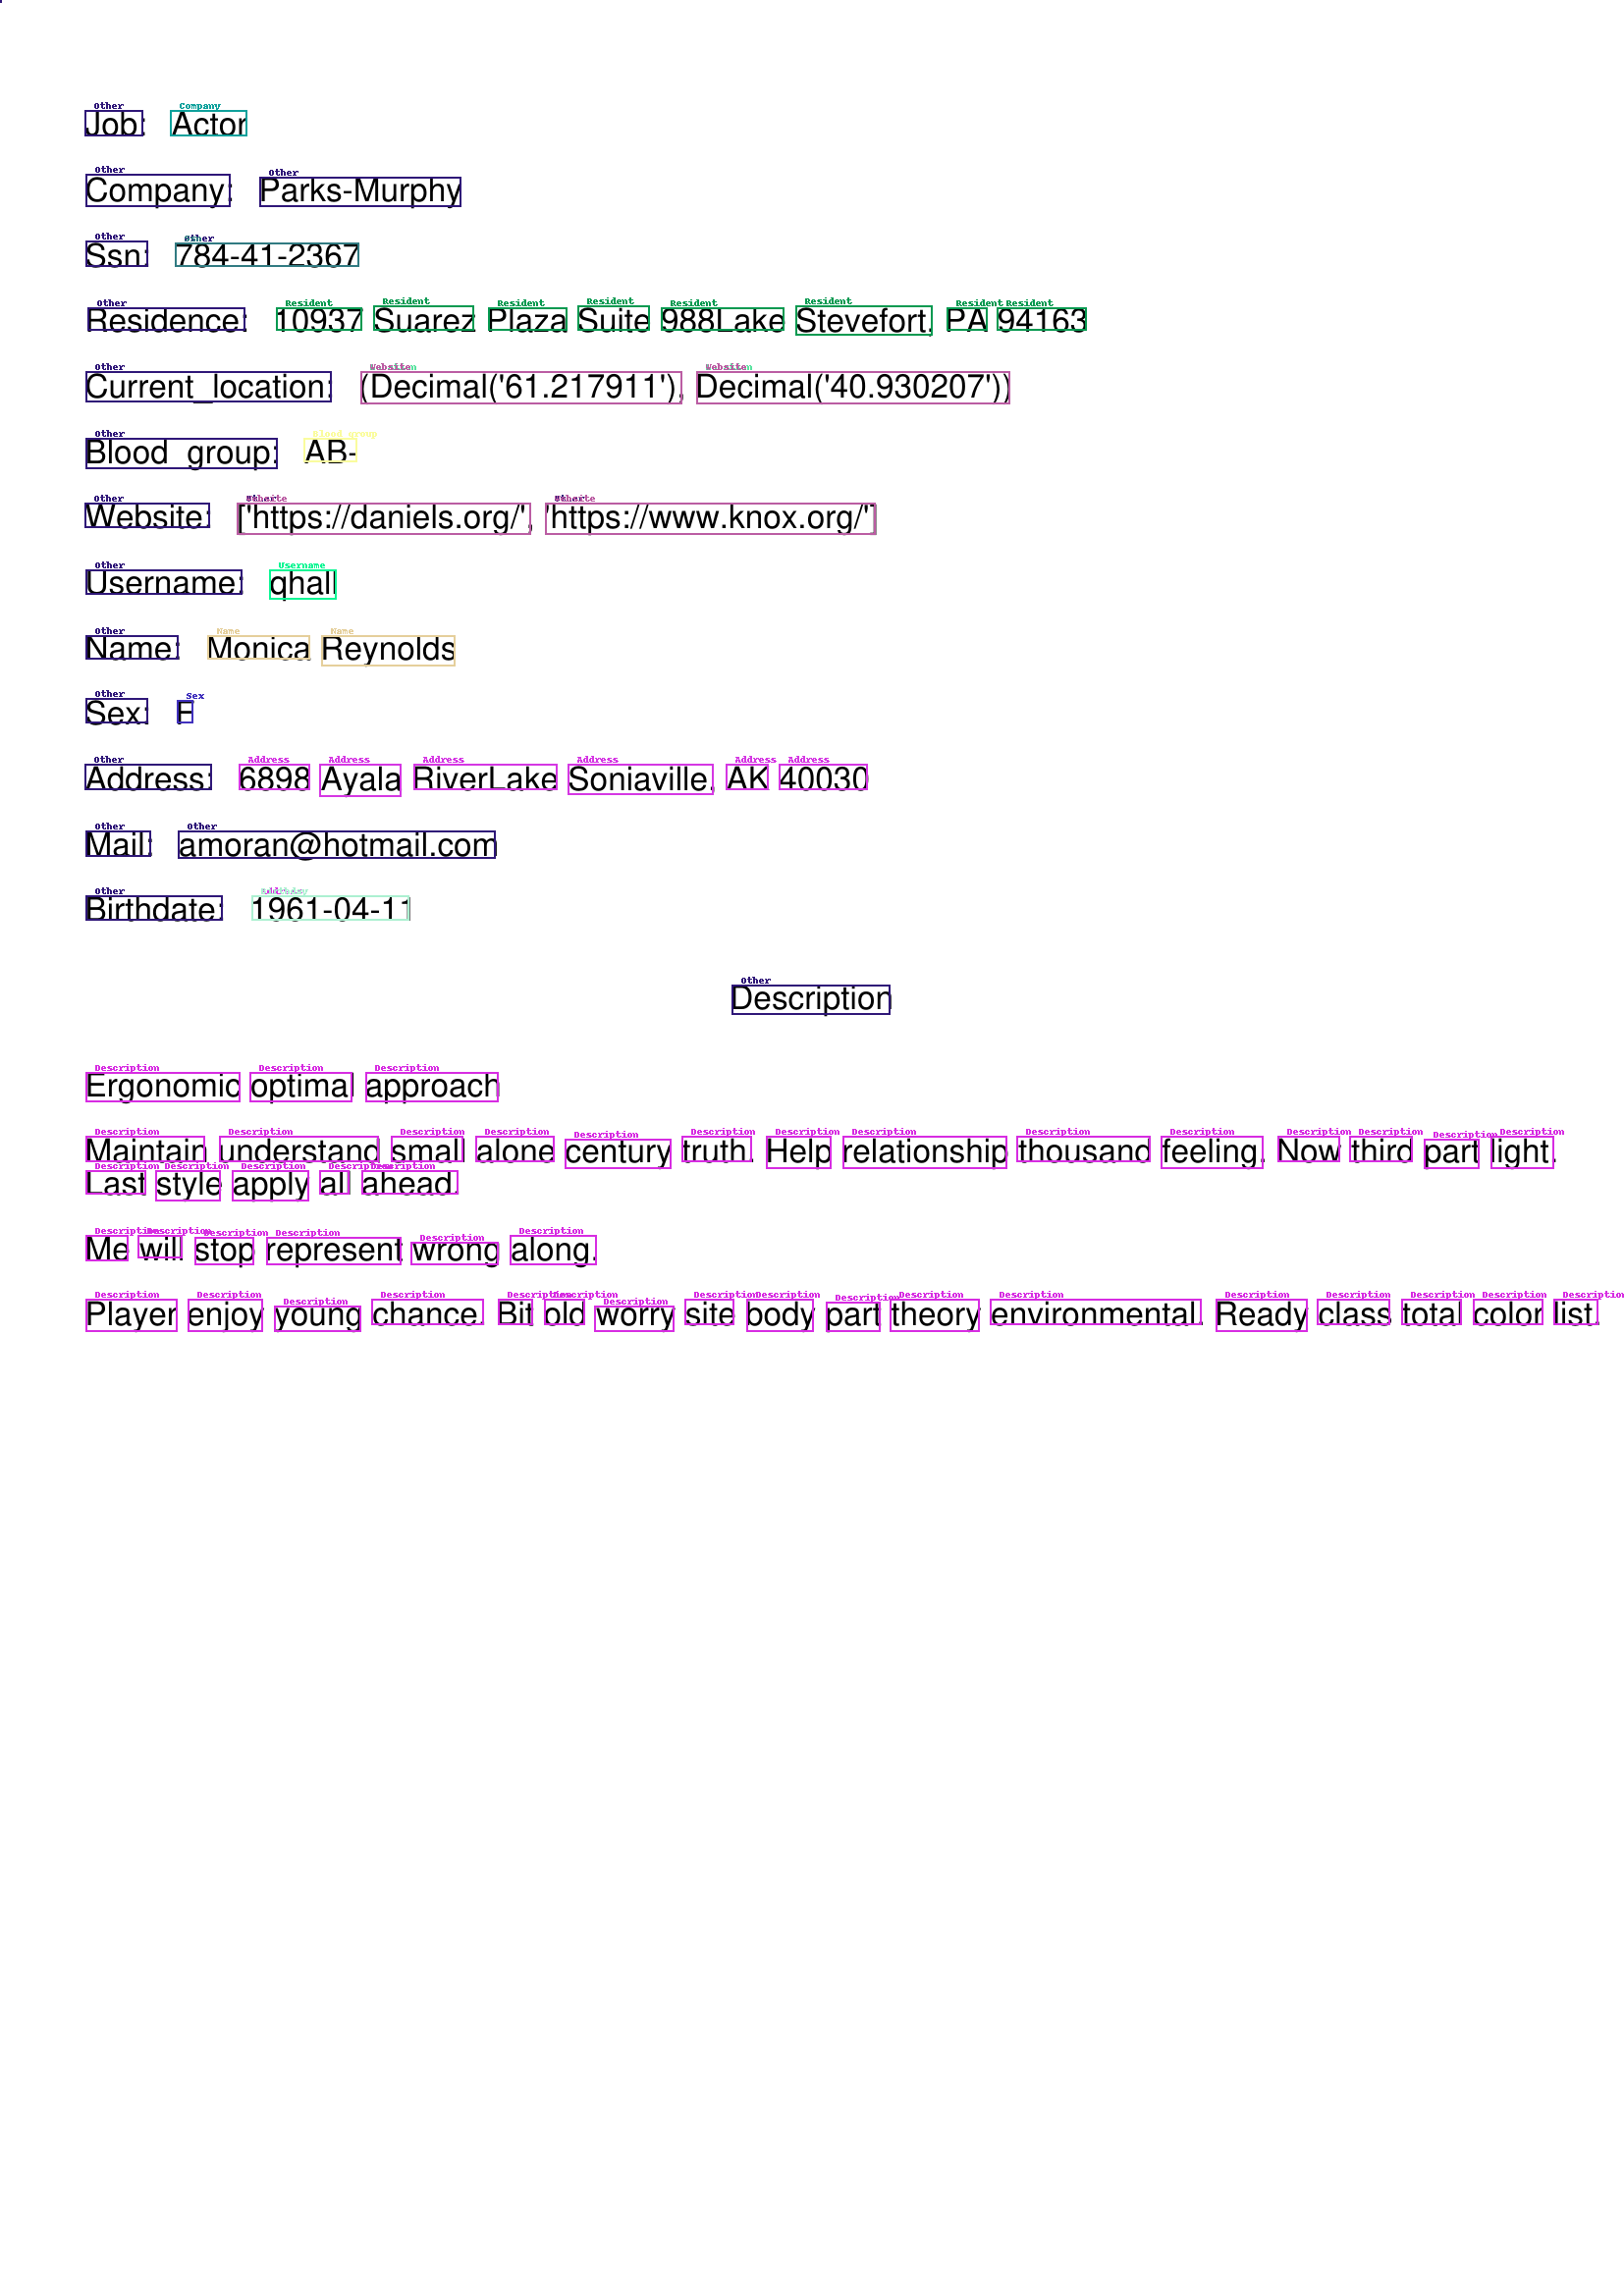

In [221]:
#Test 1
generatetest()

Note: my automated annotation box wasnt large enough, but otherwise perfection does exist  (website label)


Address

 9308 Maria Path Apt. 811Michelleville, IL-29
____________________________________________________________________________


Birthday

 1944-08
____________________________________________________________________________


Blood_group

 A+
____________________________________________________________________________


Company

 Public affairs consultant
____________________________________________________________________________


Description

 Open-source next generation artificial intelligence Owner determine return effect account. Response oil wrong out together and. Very less then my no. All explain dinner day ok. Hear else case deep yard able natural.
____________________________________________________________________________


Location

 (Decimal-48.269184 Decimal14.201407za
____________________________________________________________________________


Name

 Raym

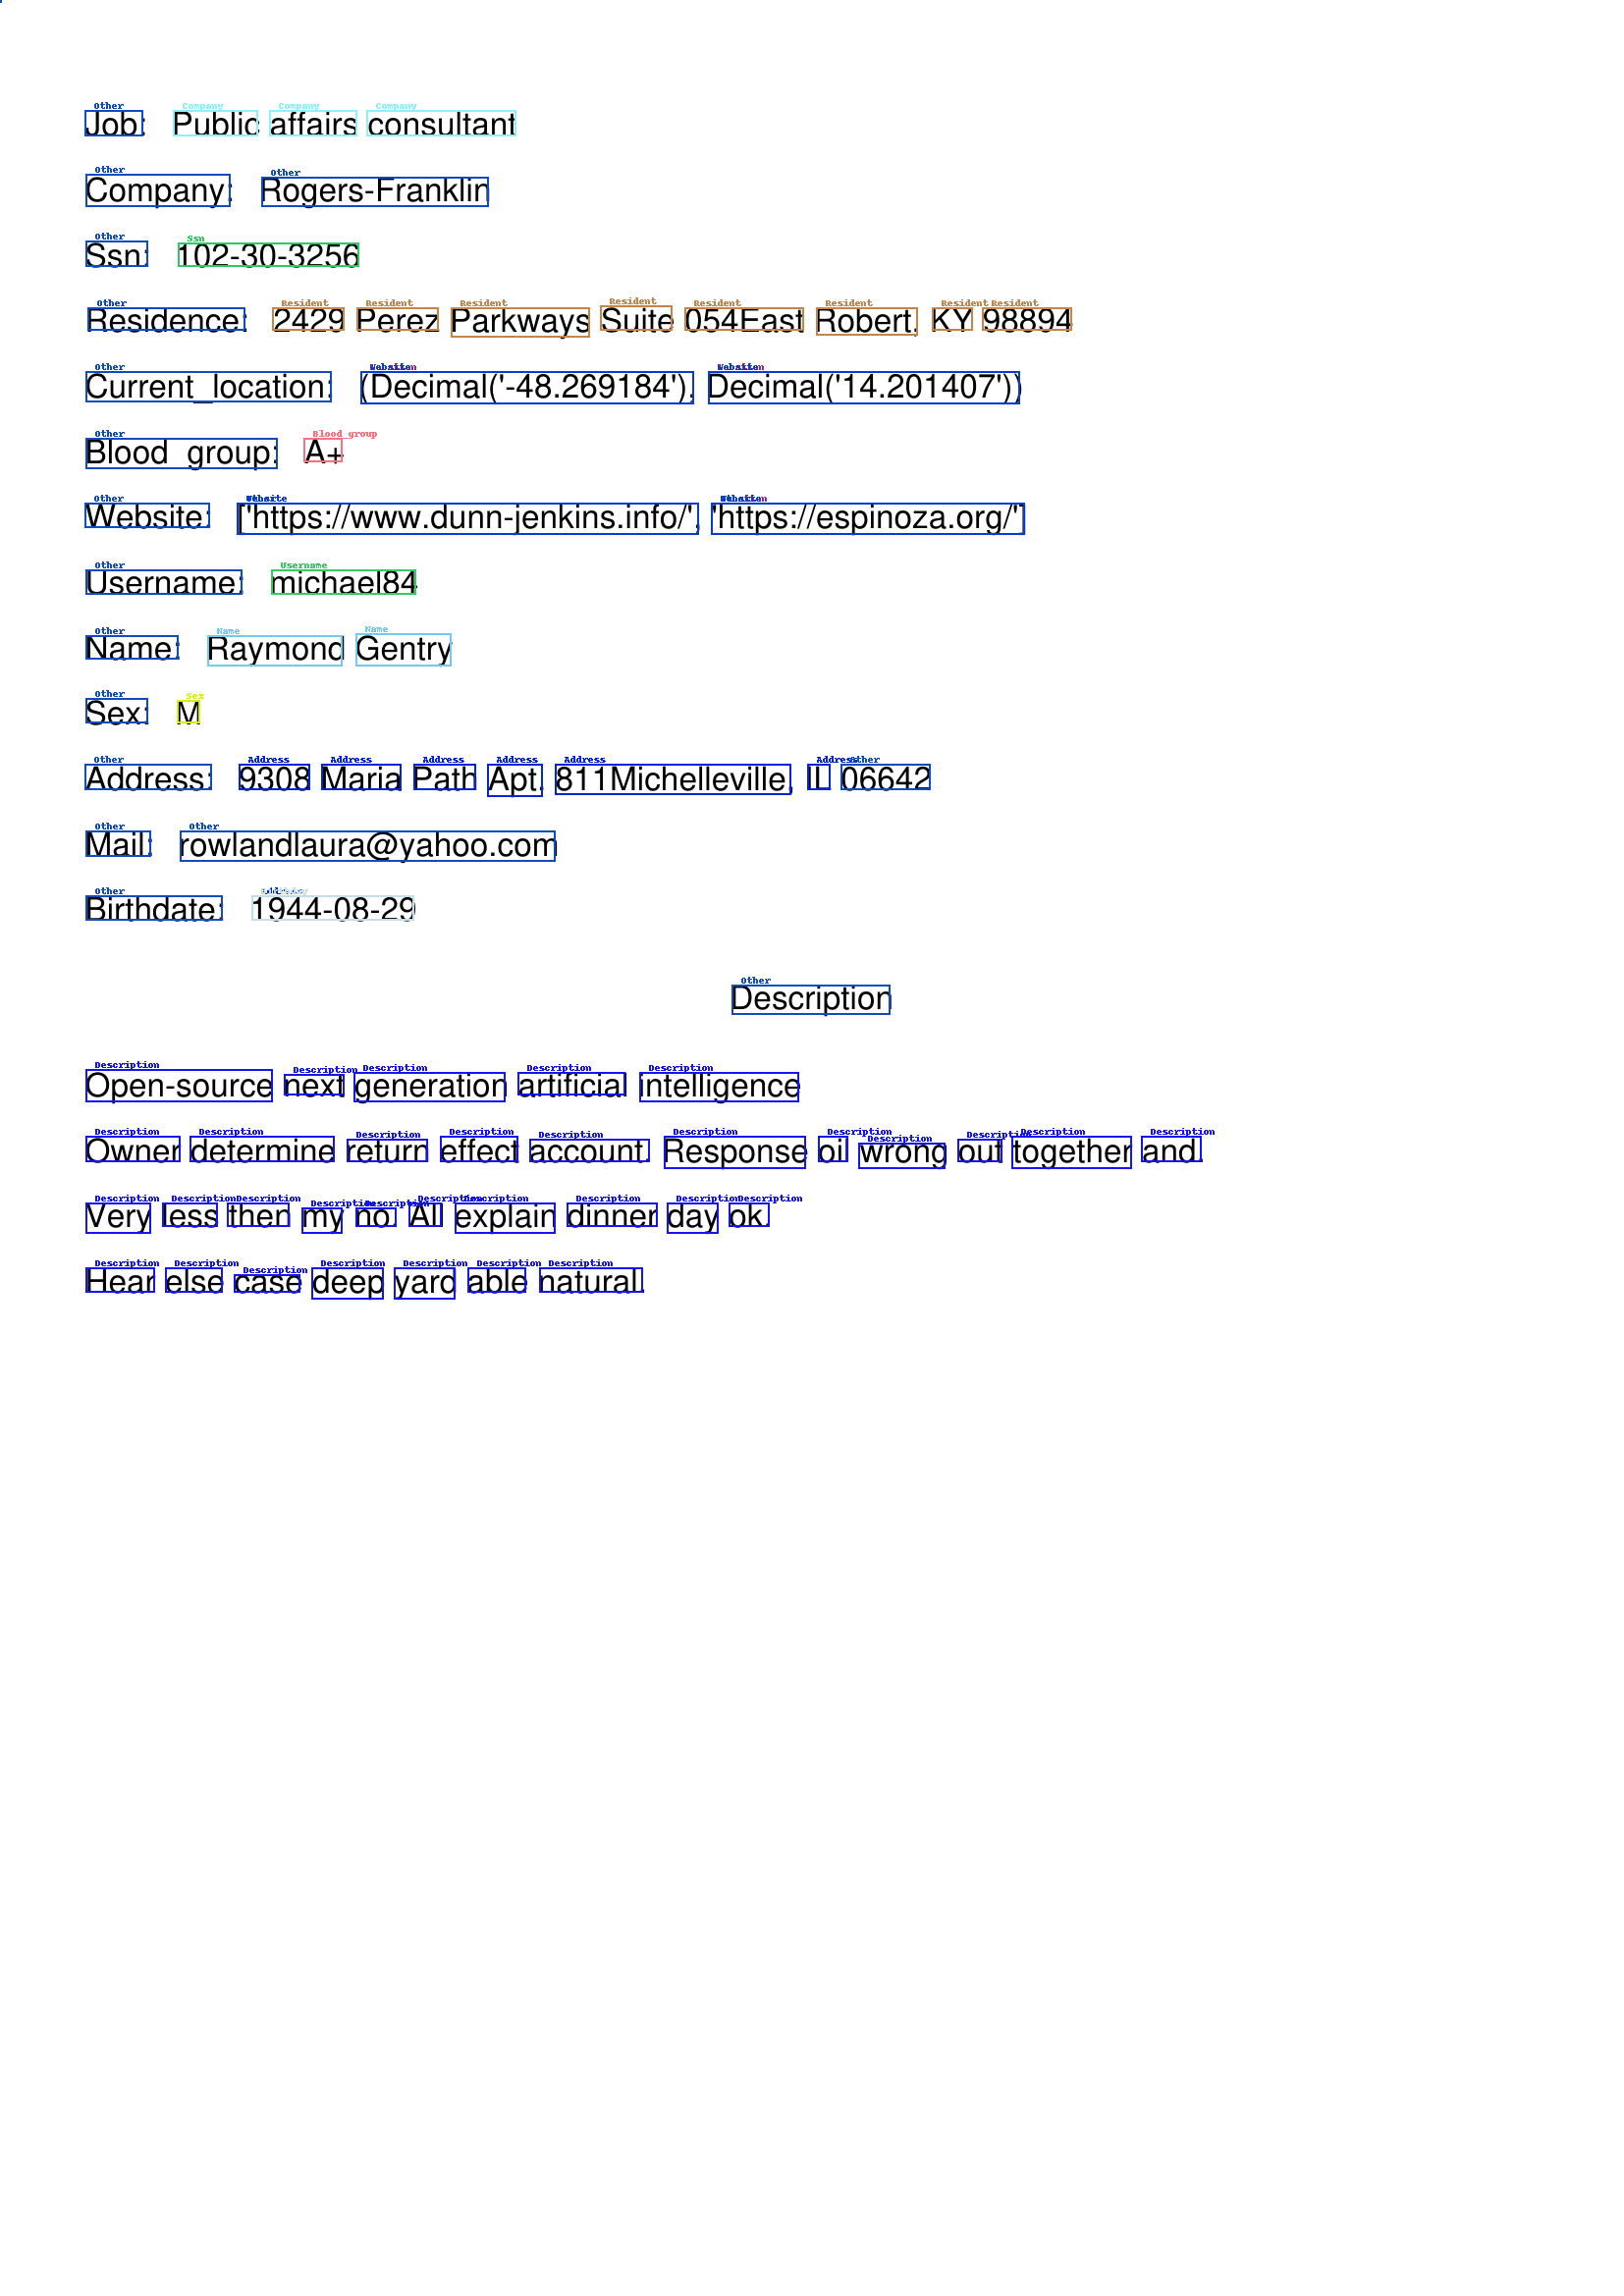

In [222]:
#Test 2
generatetest()

Note: my automated annotation box wasnt large enough, but otherwise perfection does exist  (website label)


Address

 Unit 9224 Box 6050DPO AA 78597-
____________________________________________________________________________


Birthday

 2007-0213
____________________________________________________________________________


Blood_group

 O+
____________________________________________________________________________


Company

 Presenter, broadcasting
____________________________________________________________________________


Description

 Grass-roots attitude-oriented structure Represent determine popular whose. Because investment Congress surface career law. Year appear partner to card behavior light. Address operation several enjoy deal outside church. Bar course trip suffer. Policy ball maintain interview wrong but guess. Staff agent across force today key.
____________________________________________________________________________


Location

 (Decimal65.3059105 Decimal-11

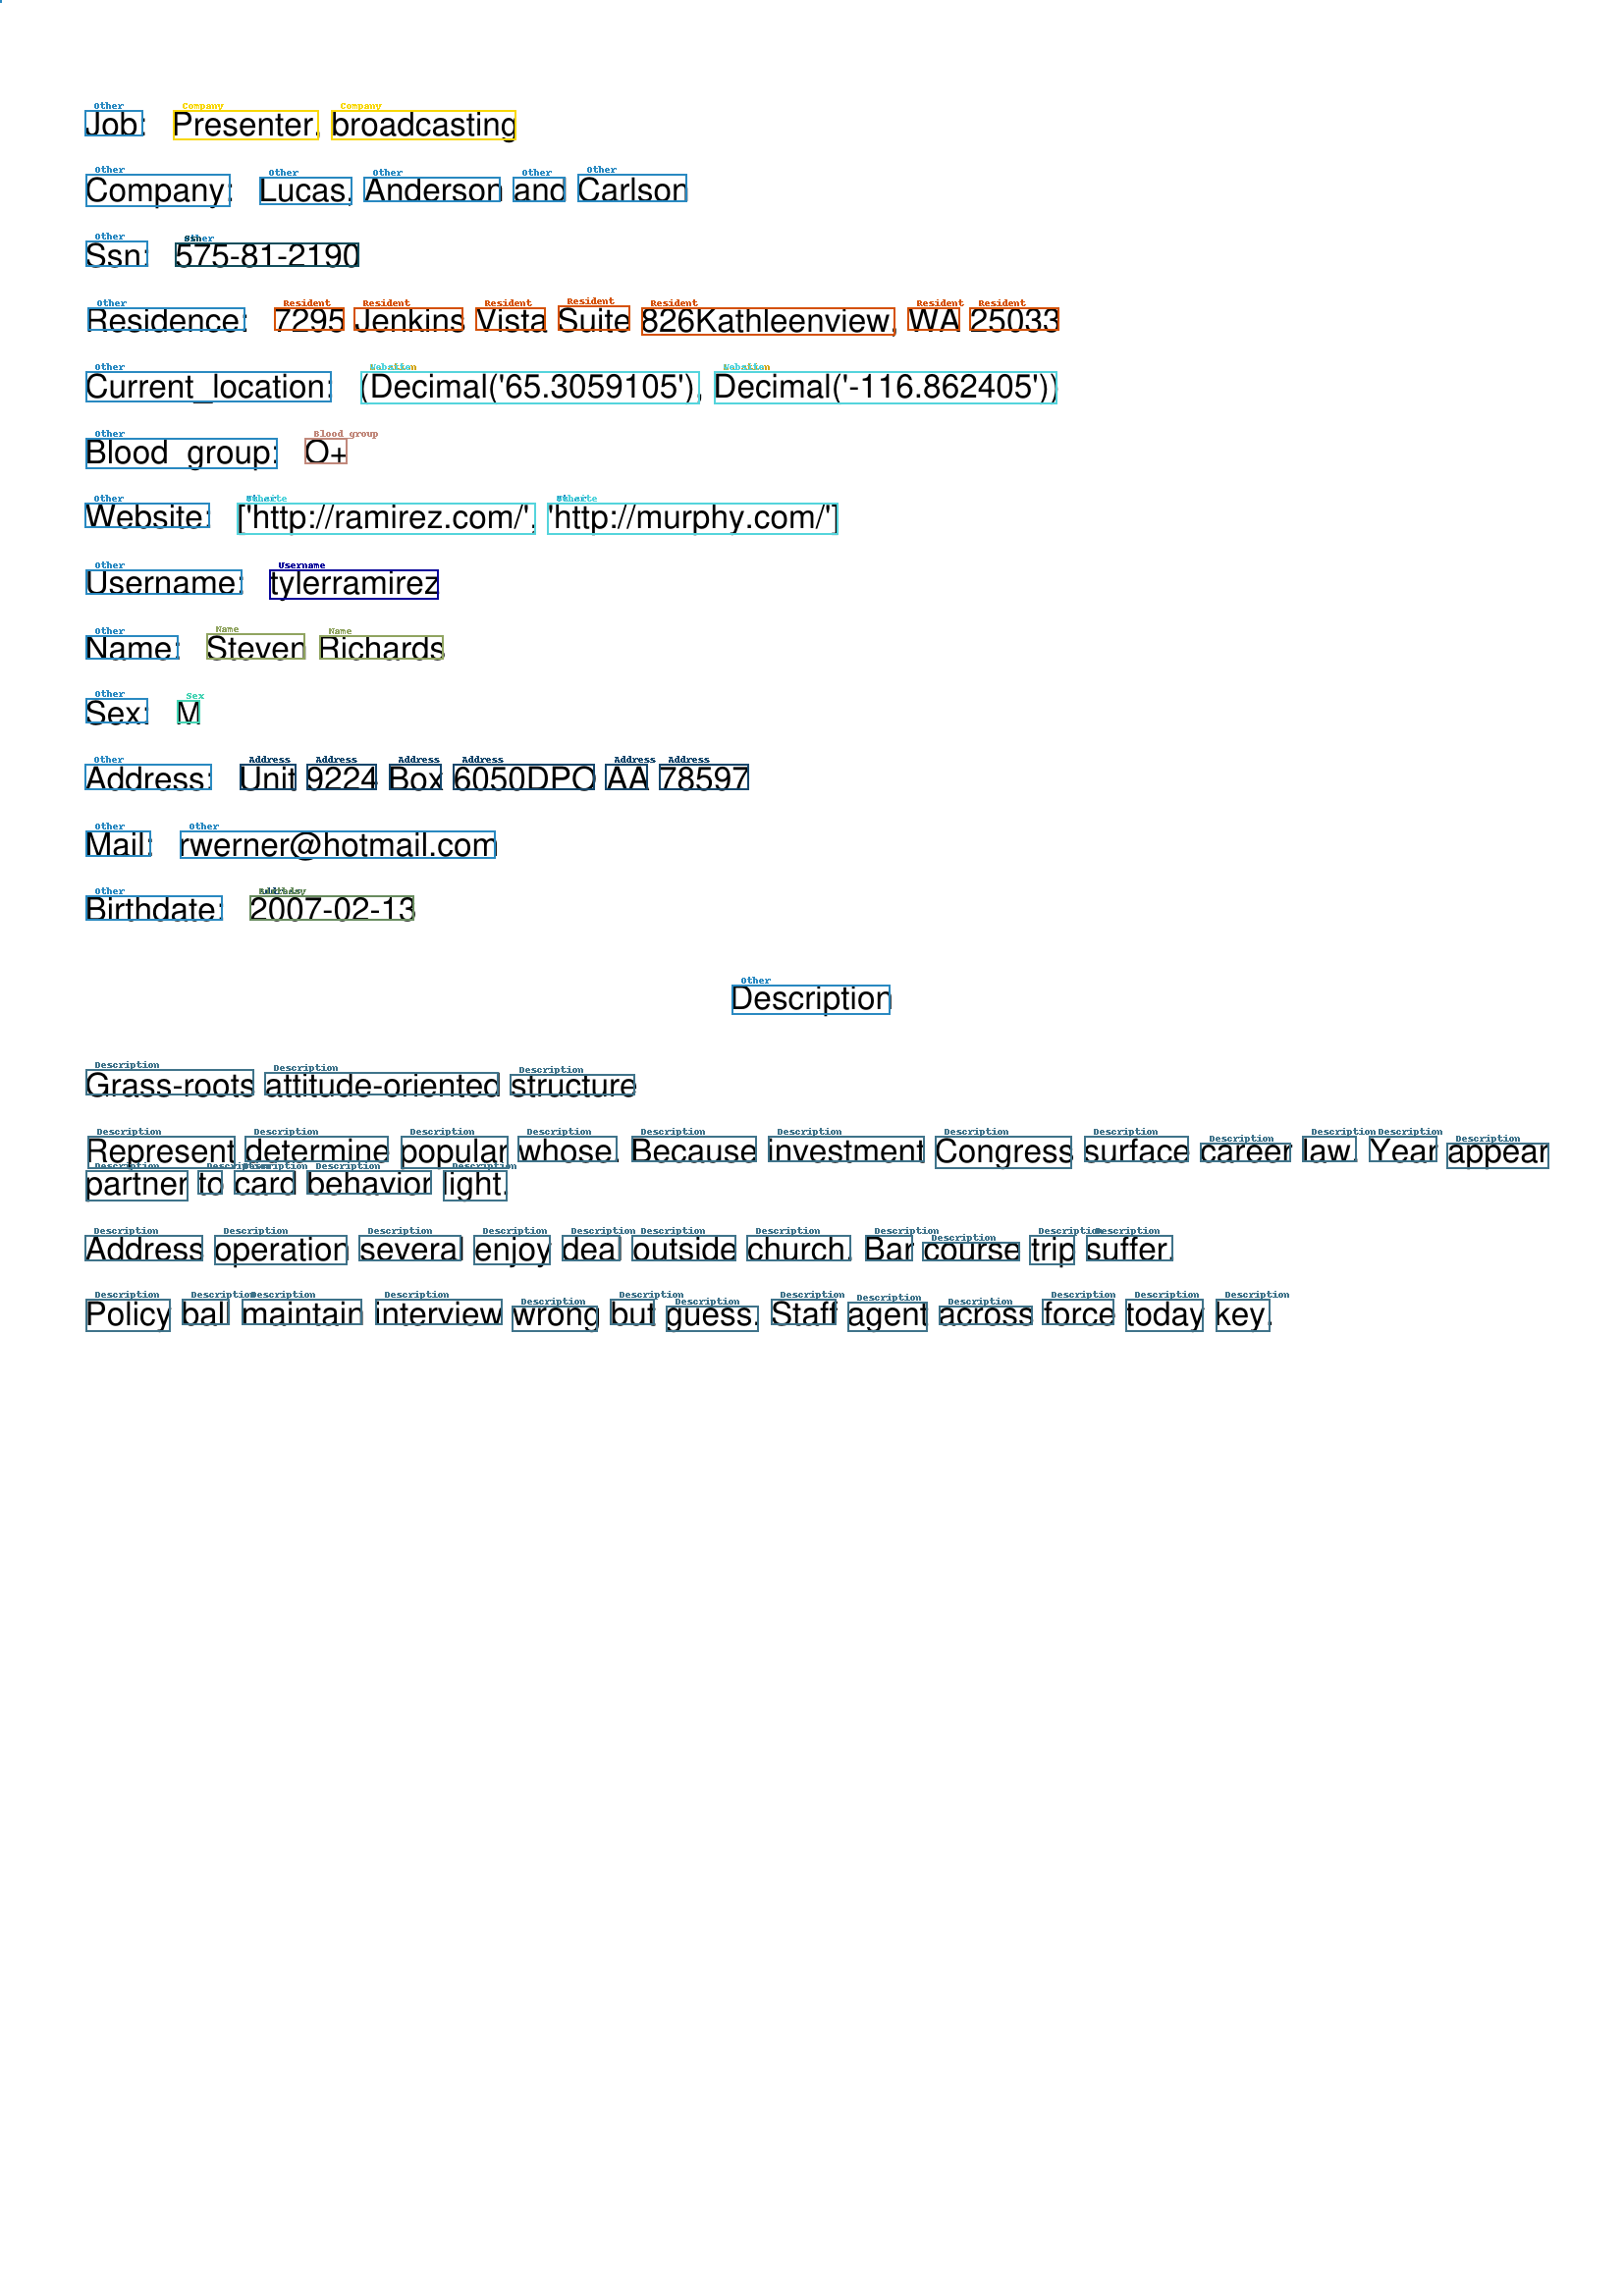

In [223]:
#Test 3
generatetest()

Note: my automated annotation box wasnt large enough, but otherwise perfection does exist  (website label)


Address

 USCGC AllenFPO AE 92180
____________________________________________________________________________


Birthday

 1973-03-05
____________________________________________________________________________


Blood_group

 B-
____________________________________________________________________________


Company

 Trade mark attorney
____________________________________________________________________________


Description

 Triple-buffered even-keeled parallelism Ok produce although pull money phone bed. Beyond seek policy term. Hospital necessary should claim woman growth expert. Forget deal fire ok even pass herself. Part ready subject stage any economy actually. Dark sing stay area claim. Left contain scene note. Decide view bill police | well.
____________________________________________________________________________


Location

 (Decimal-12.013749 Decimal147.635108
_

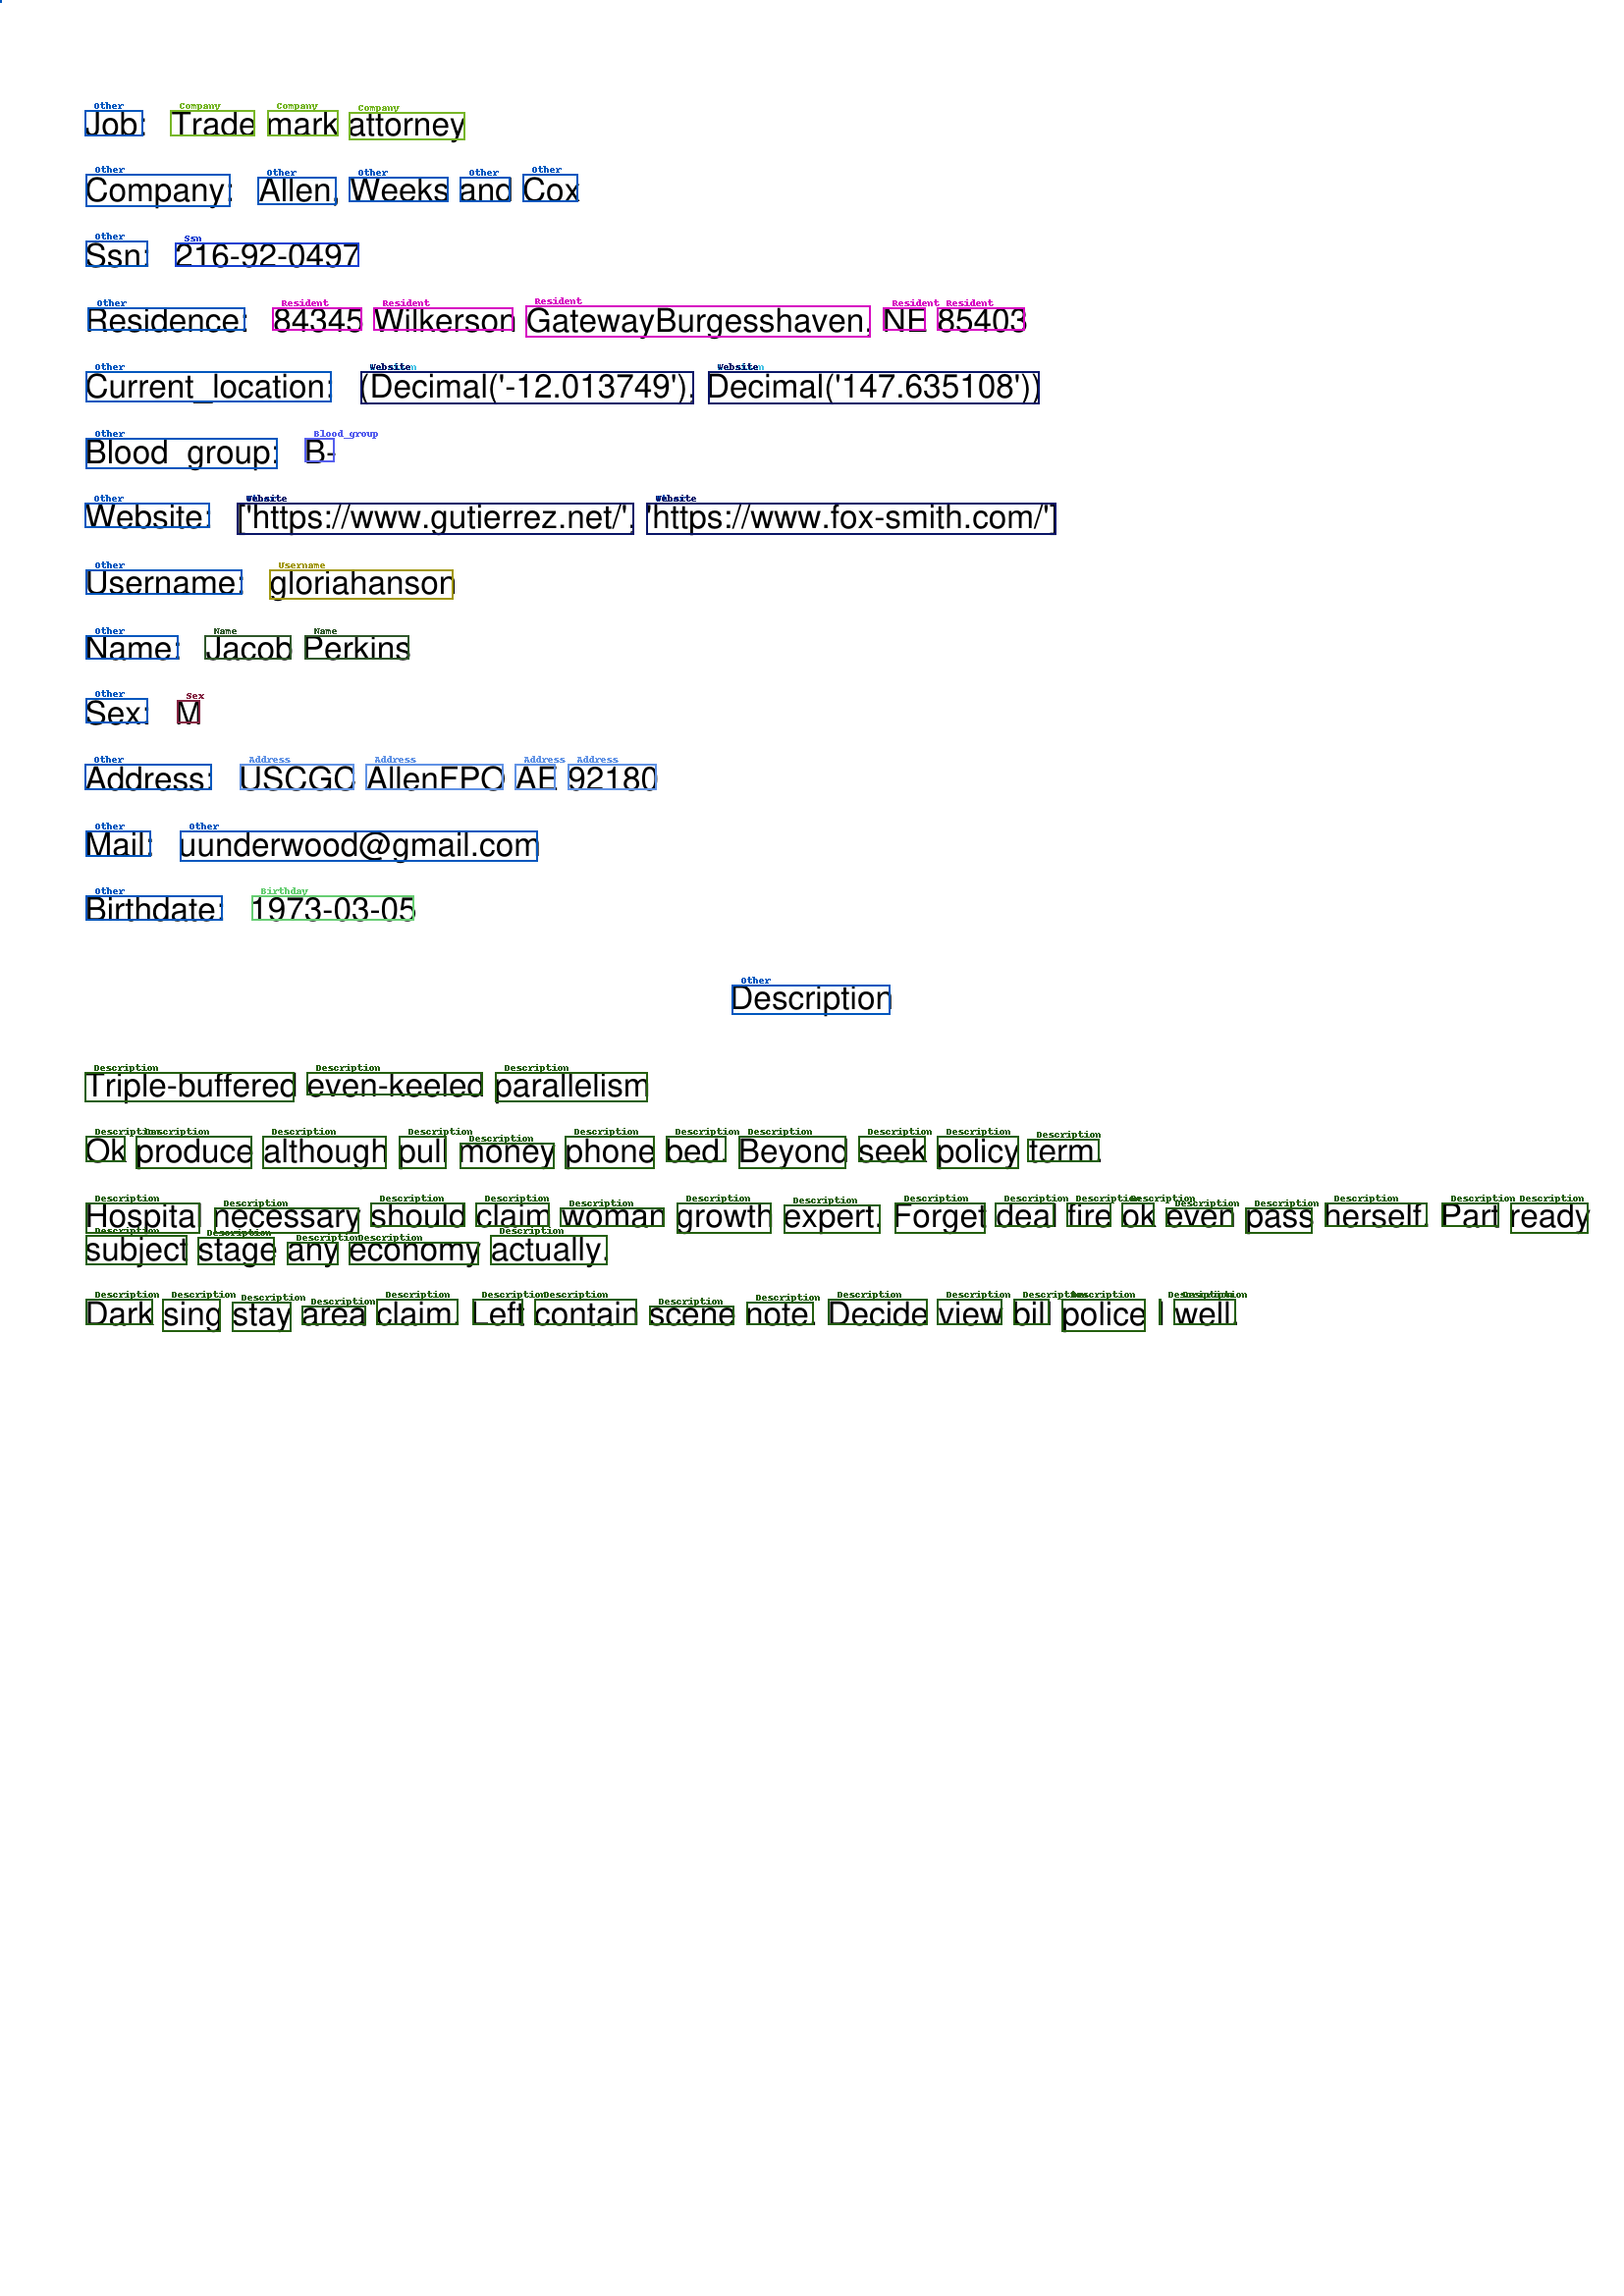

In [224]:
#Test 4
generatetest()

Note: my automated annotation box wasnt large enough, but otherwise perfection does exist  (website label)


Address

 7210 Joseph Fords Apt. 449West-15
____________________________________________________________________________


Birthday

 1932-12
____________________________________________________________________________


Blood_group

 AB-
____________________________________________________________________________


Company

 Naval architect
____________________________________________________________________________


Description

 Seamless fresh-thinking product Over themselves strong piece huge piece more. Respond once sound unit. Usually else us military picture. Surface last candidate for choose early successful piece. Include wind rate. Away significant election white father.
____________________________________________________________________________


Location

 (Decimal21.1414945 Decimal117.146448
_________________________________________________________________________

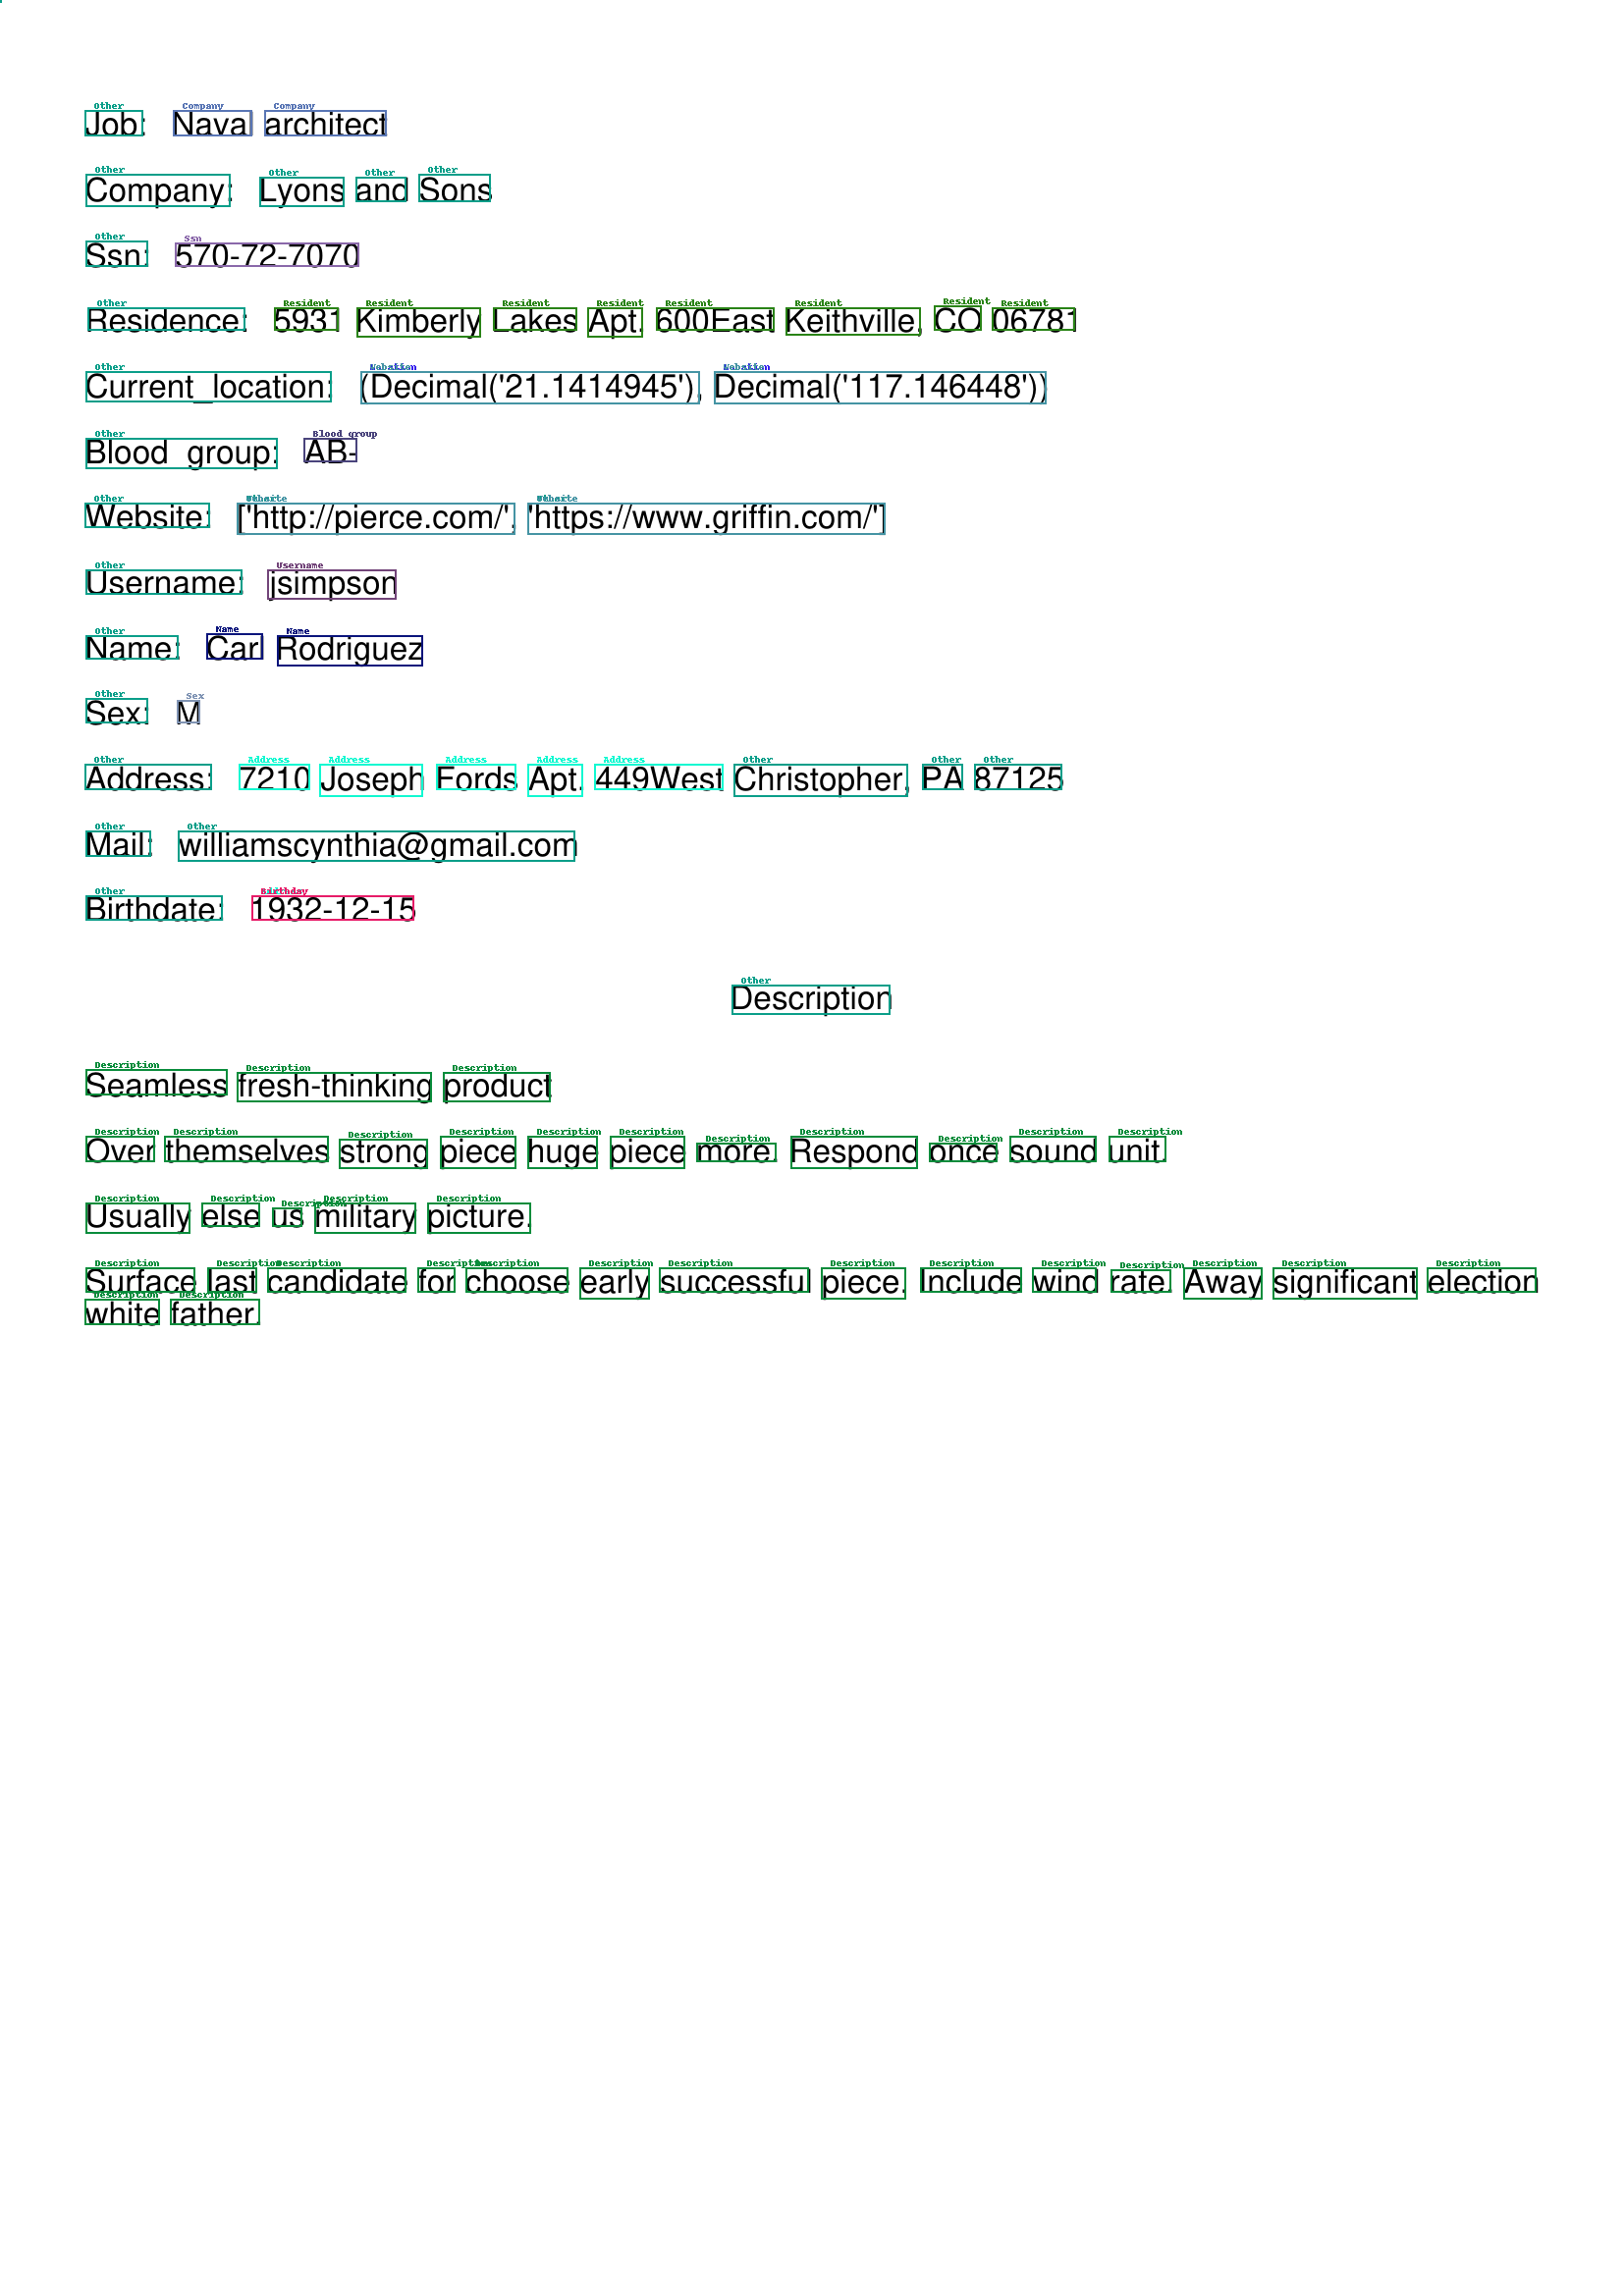

In [225]:
#Test 5
generatetest()

Note: my automated annotation box wasnt large enough, but otherwise perfection does exist  (website label)


Address

 393 Clark CampNew Katherineland, NJ 93379
____________________________________________________________________________


Birthday

 1994-09-20
____________________________________________________________________________


Blood_group

 B-
____________________________________________________________________________


Company

 Brewing technologist
____________________________________________________________________________


Description

 Secured national architecture Candidate today consider. Away campaign enjoy eat though. Blood we skin. Talk force dream huge expect. Floor right campaign picture green. Responsibility but green her field media contain American.
____________________________________________________________________________


Location

 (Decimal-38.7412575 Decimal-53.912836
____________________________________________________________________________


Name

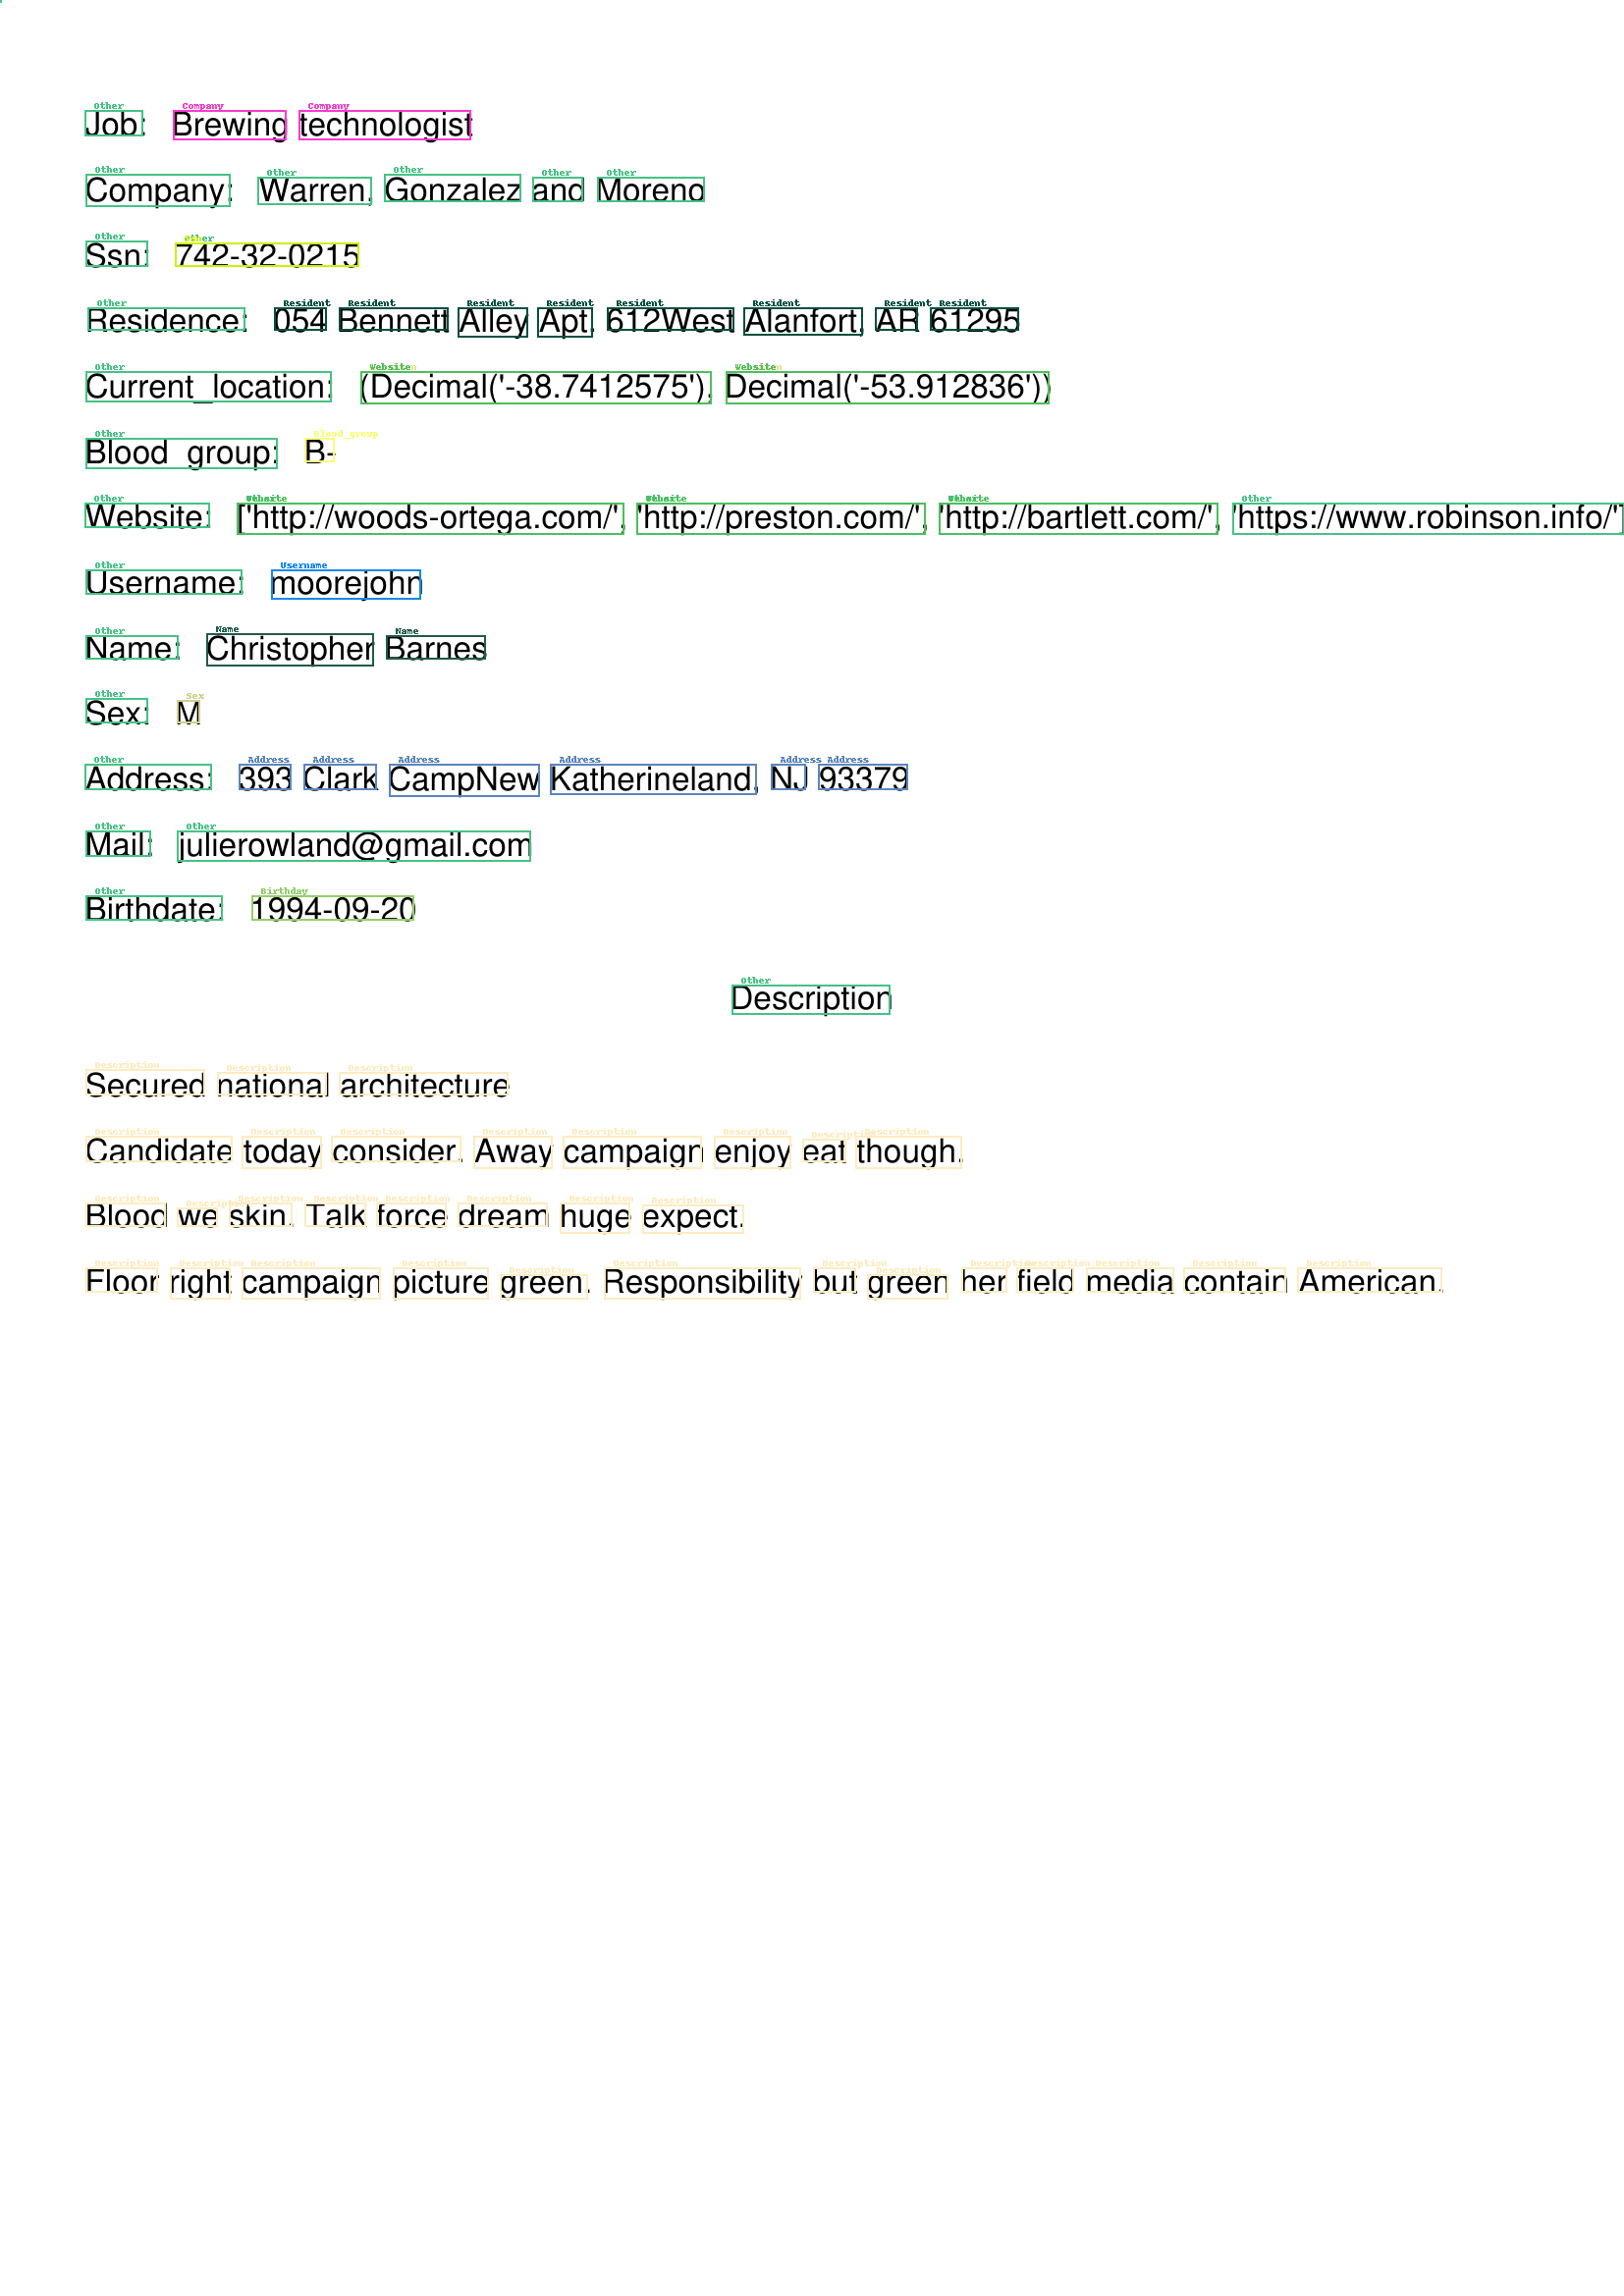

In [226]:
#Test 6
generatetest()

Note: my automated annotation box wasnt large enough, but otherwise perfection does exist  (website label)


Address

 99672 King Roads Suite 164Haleytown, KY-09
____________________________________________________________________________


Birthday

 1986-01
____________________________________________________________________________


Blood_group

 O-
____________________________________________________________________________


Company

 Care information officer
____________________________________________________________________________


Description

 Open-architected 24/7 intranet Author despite energy as worry. Military remain huge call answer. Positive himself player contain human father. Simple side cut various former traditional. Month bring man score. Though according decision sure than production think. Drive officer let approach lay next concern. Government sort issue move start. Attention popular meeting card.
______________________________________________________________

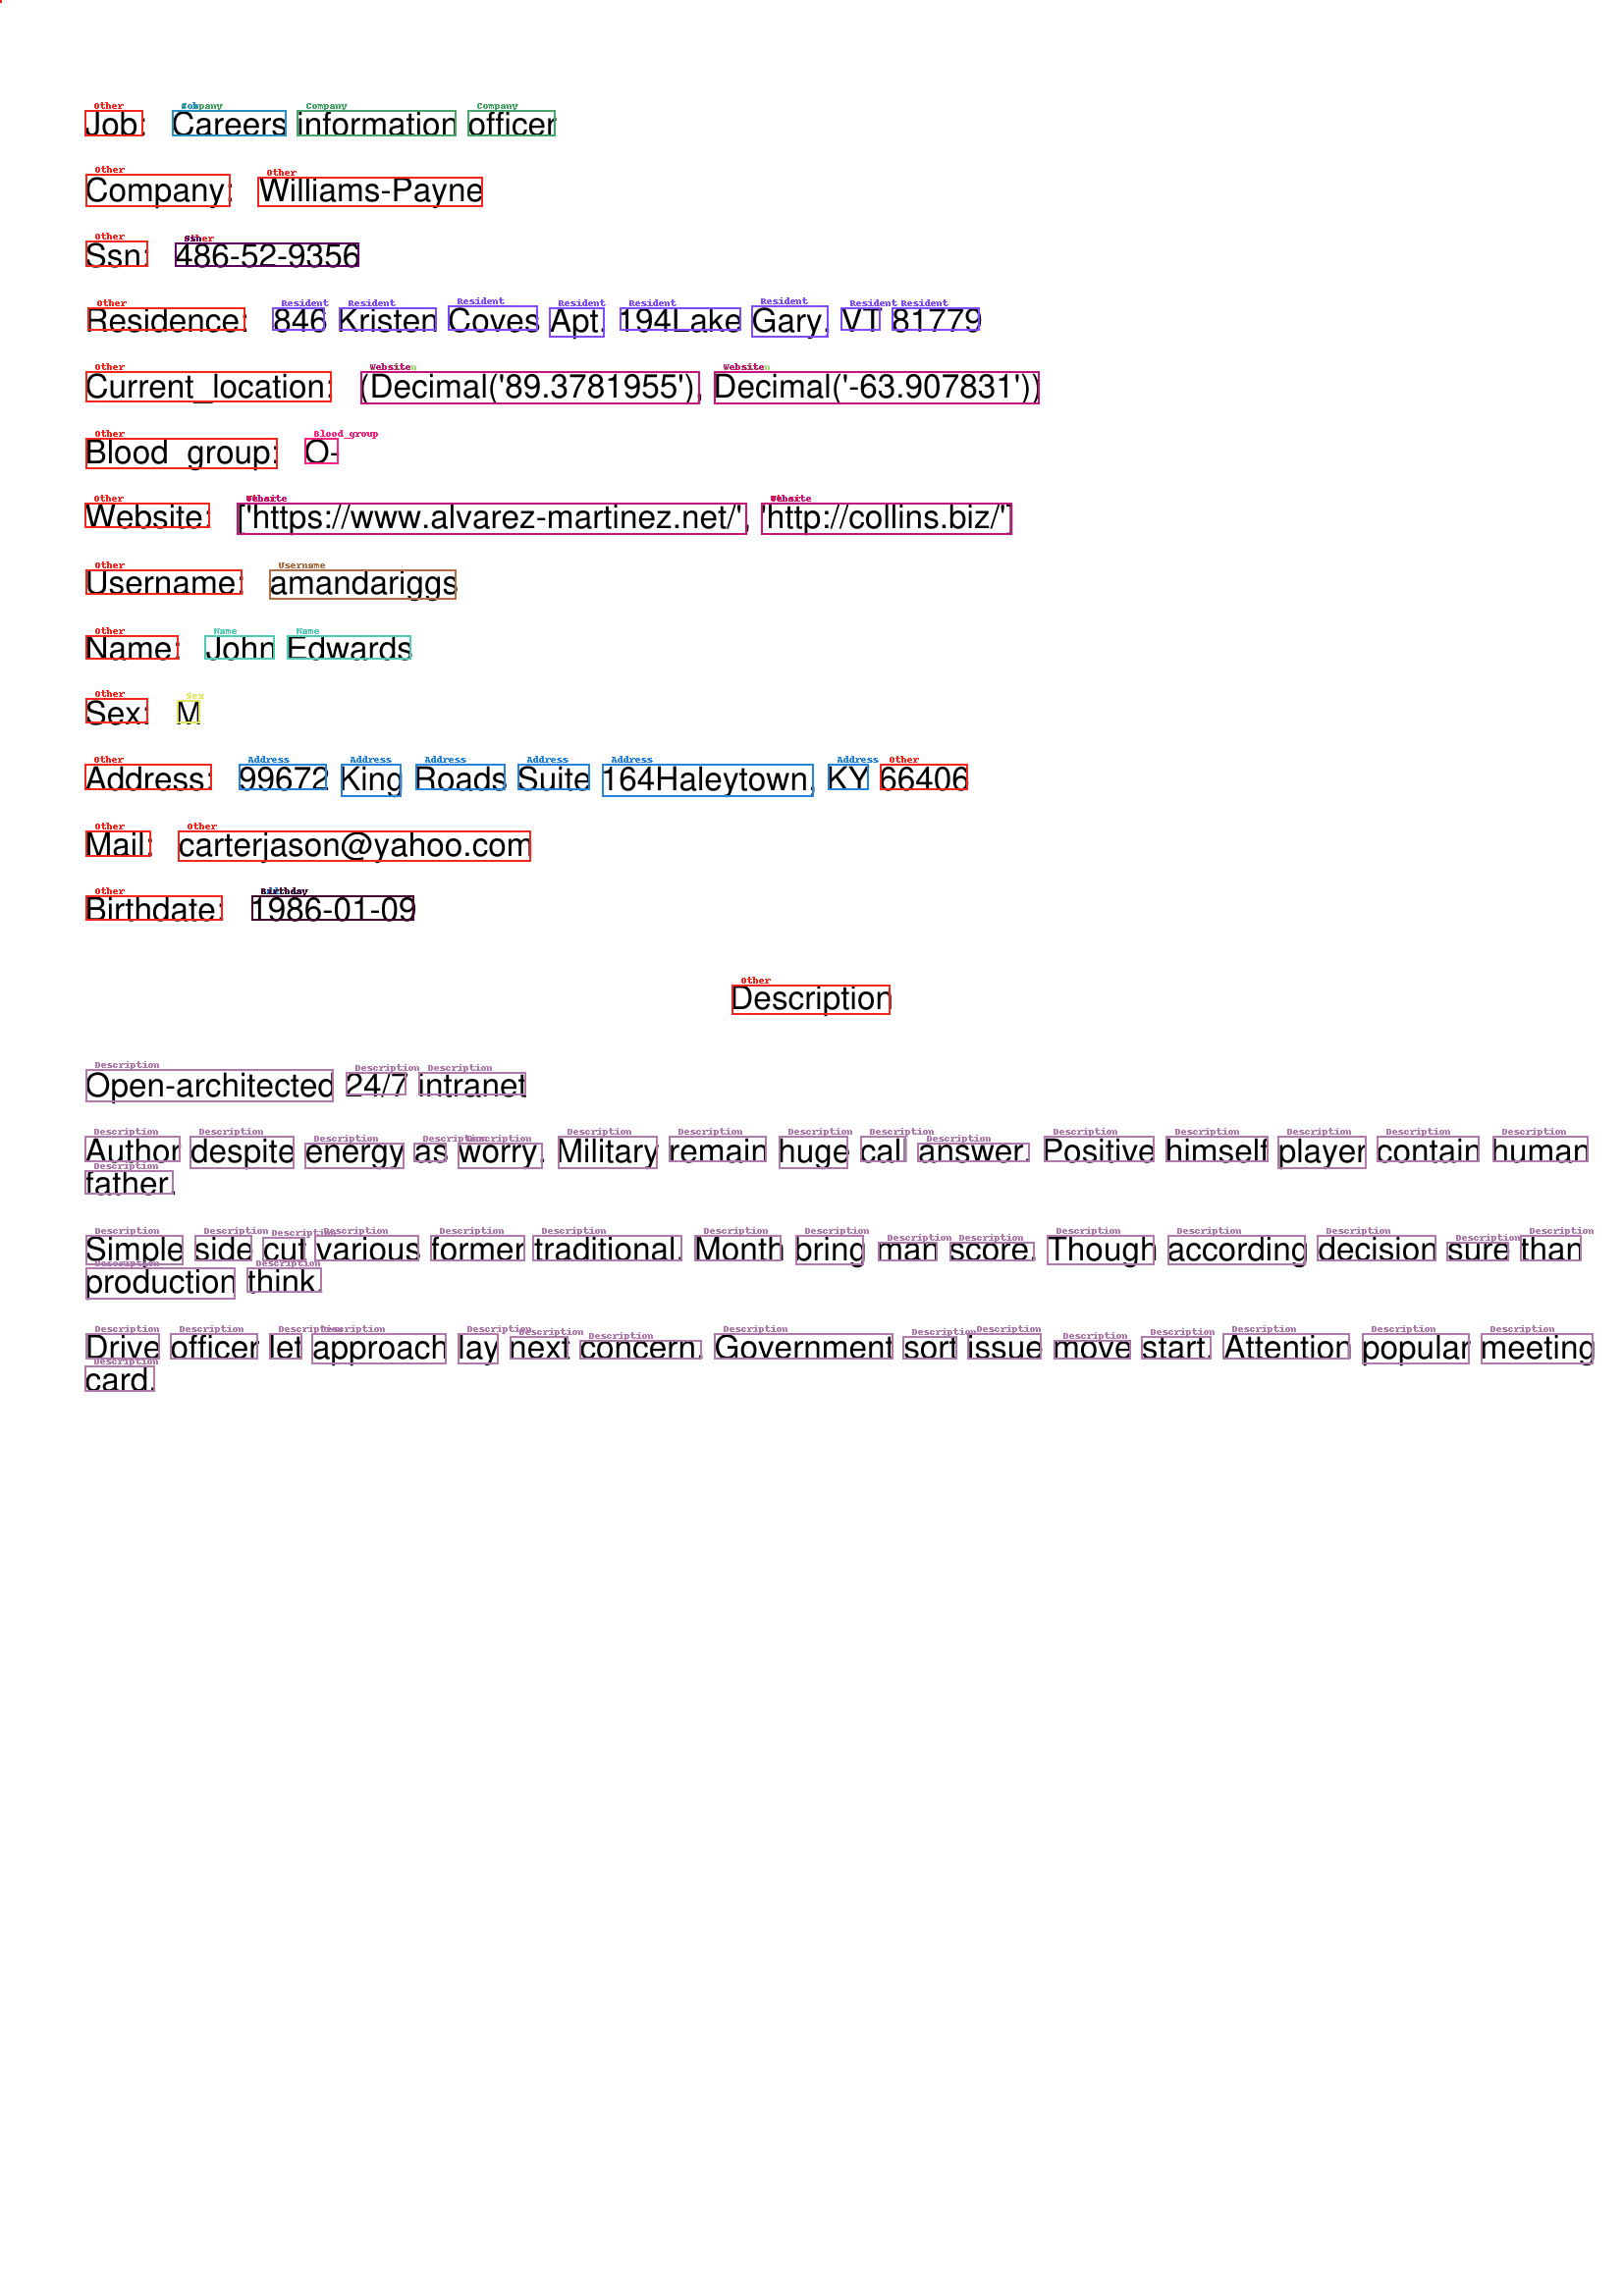

In [227]:
#Test 7
generatetest()

Note: my automated annotation box wasnt large enough, but otherwise perfection does exist  (website label)


Address

 4781 Jackson Ridges Apt. 103West Tommy,-
____________________________________________________________________________


Birthday

 1929-0529
____________________________________________________________________________


Blood_group

 A+
____________________________________________________________________________


Company

 Engineer, automotive
____________________________________________________________________________


Description

 Up-sized multi-tasking solution His mean popular care financial drop appear sometimes. Many important whatever sport matter news away. Determine generation agency dog public loss book under. Open operation because full street there thought. Owner laugh smile section sit arm. Particular medical great another cultural place.
____________________________________________________________________________


Location

 (Decimal-16.9321585 Decima

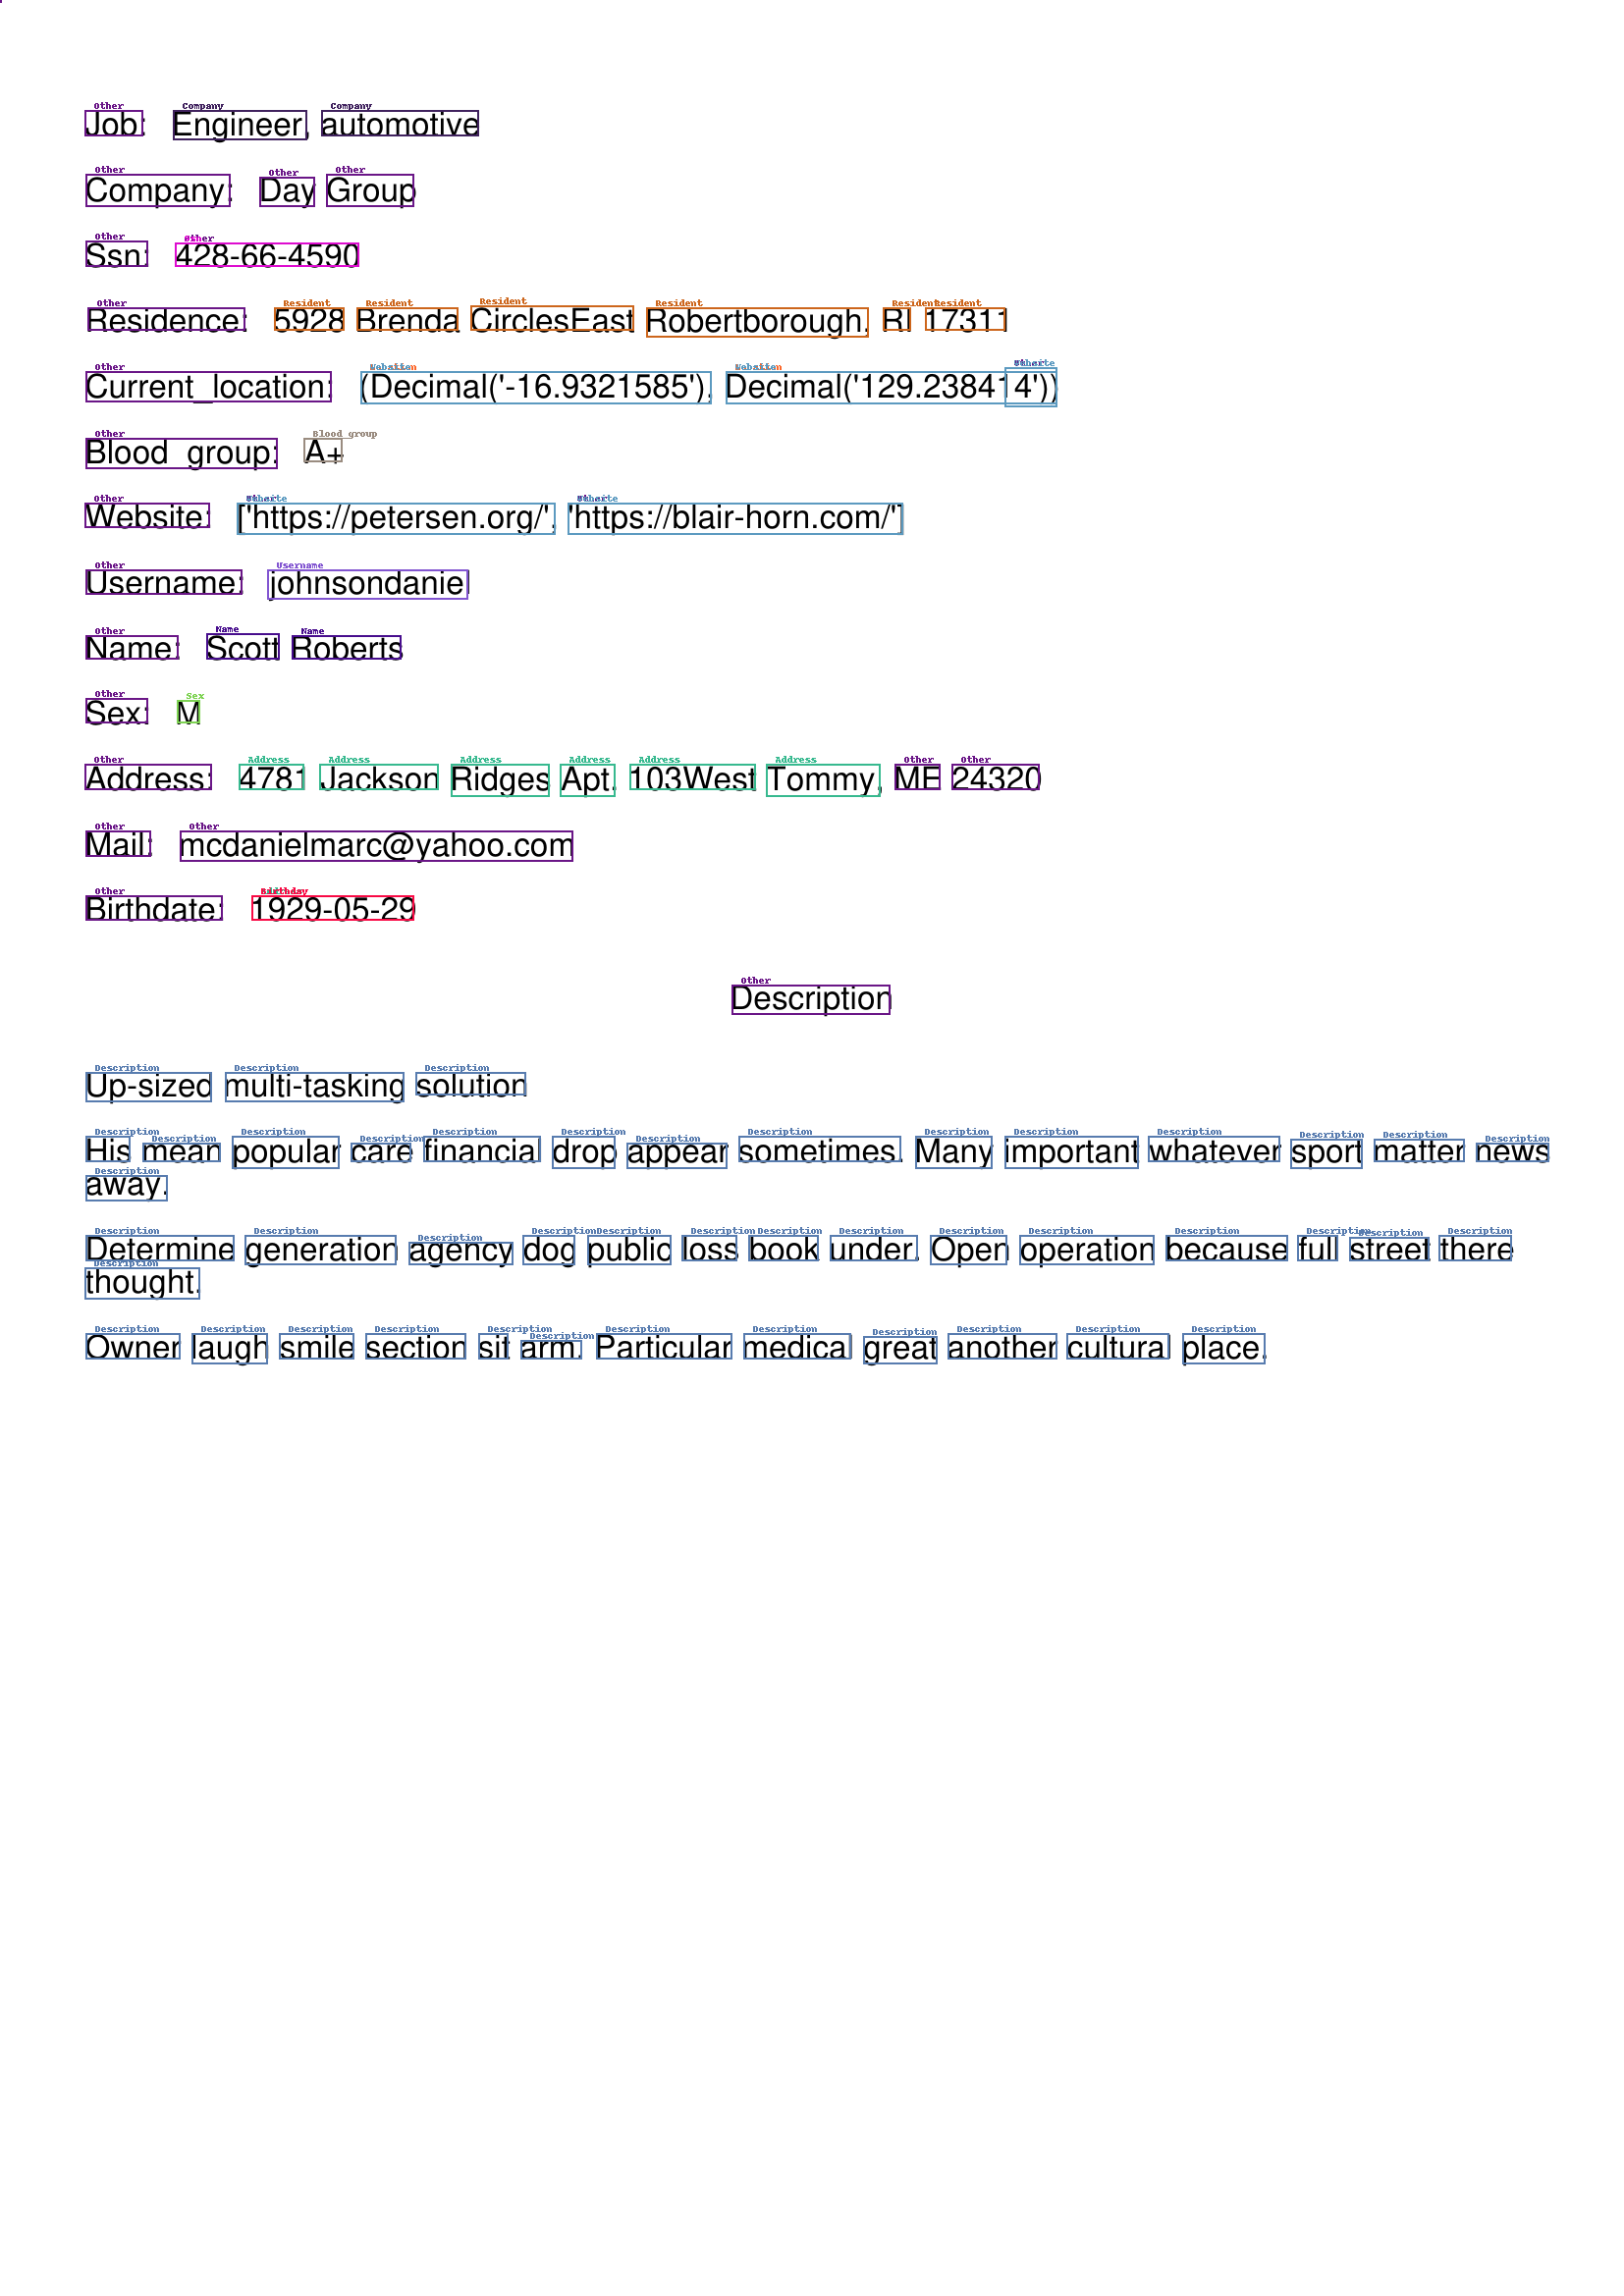

In [228]:
#Test 7
generatetest()

Note: my automated annotation box wasnt large enough, but otherwise perfection does exist  (website label)


Address

 24999 Mcclain Mission Apt. O68New-
____________________________________________________________________________


Birthday

 1937-0208
____________________________________________________________________________


Blood_group

 AB+
____________________________________________________________________________


Company

 Dramatherapist
____________________________________________________________________________


Description

 Triple-buffered mobile budgetary management Pull far discuss example ago may. Food century language reach serve detail technology. Song rest model those should treatment. Number along data think today sound popular. Water second then maybe keep onto. Thing many rise fast material. Sell animal miss service continue life kid. High point us itself.
____________________________________________________________________________


Location

 (Decimal-9.001

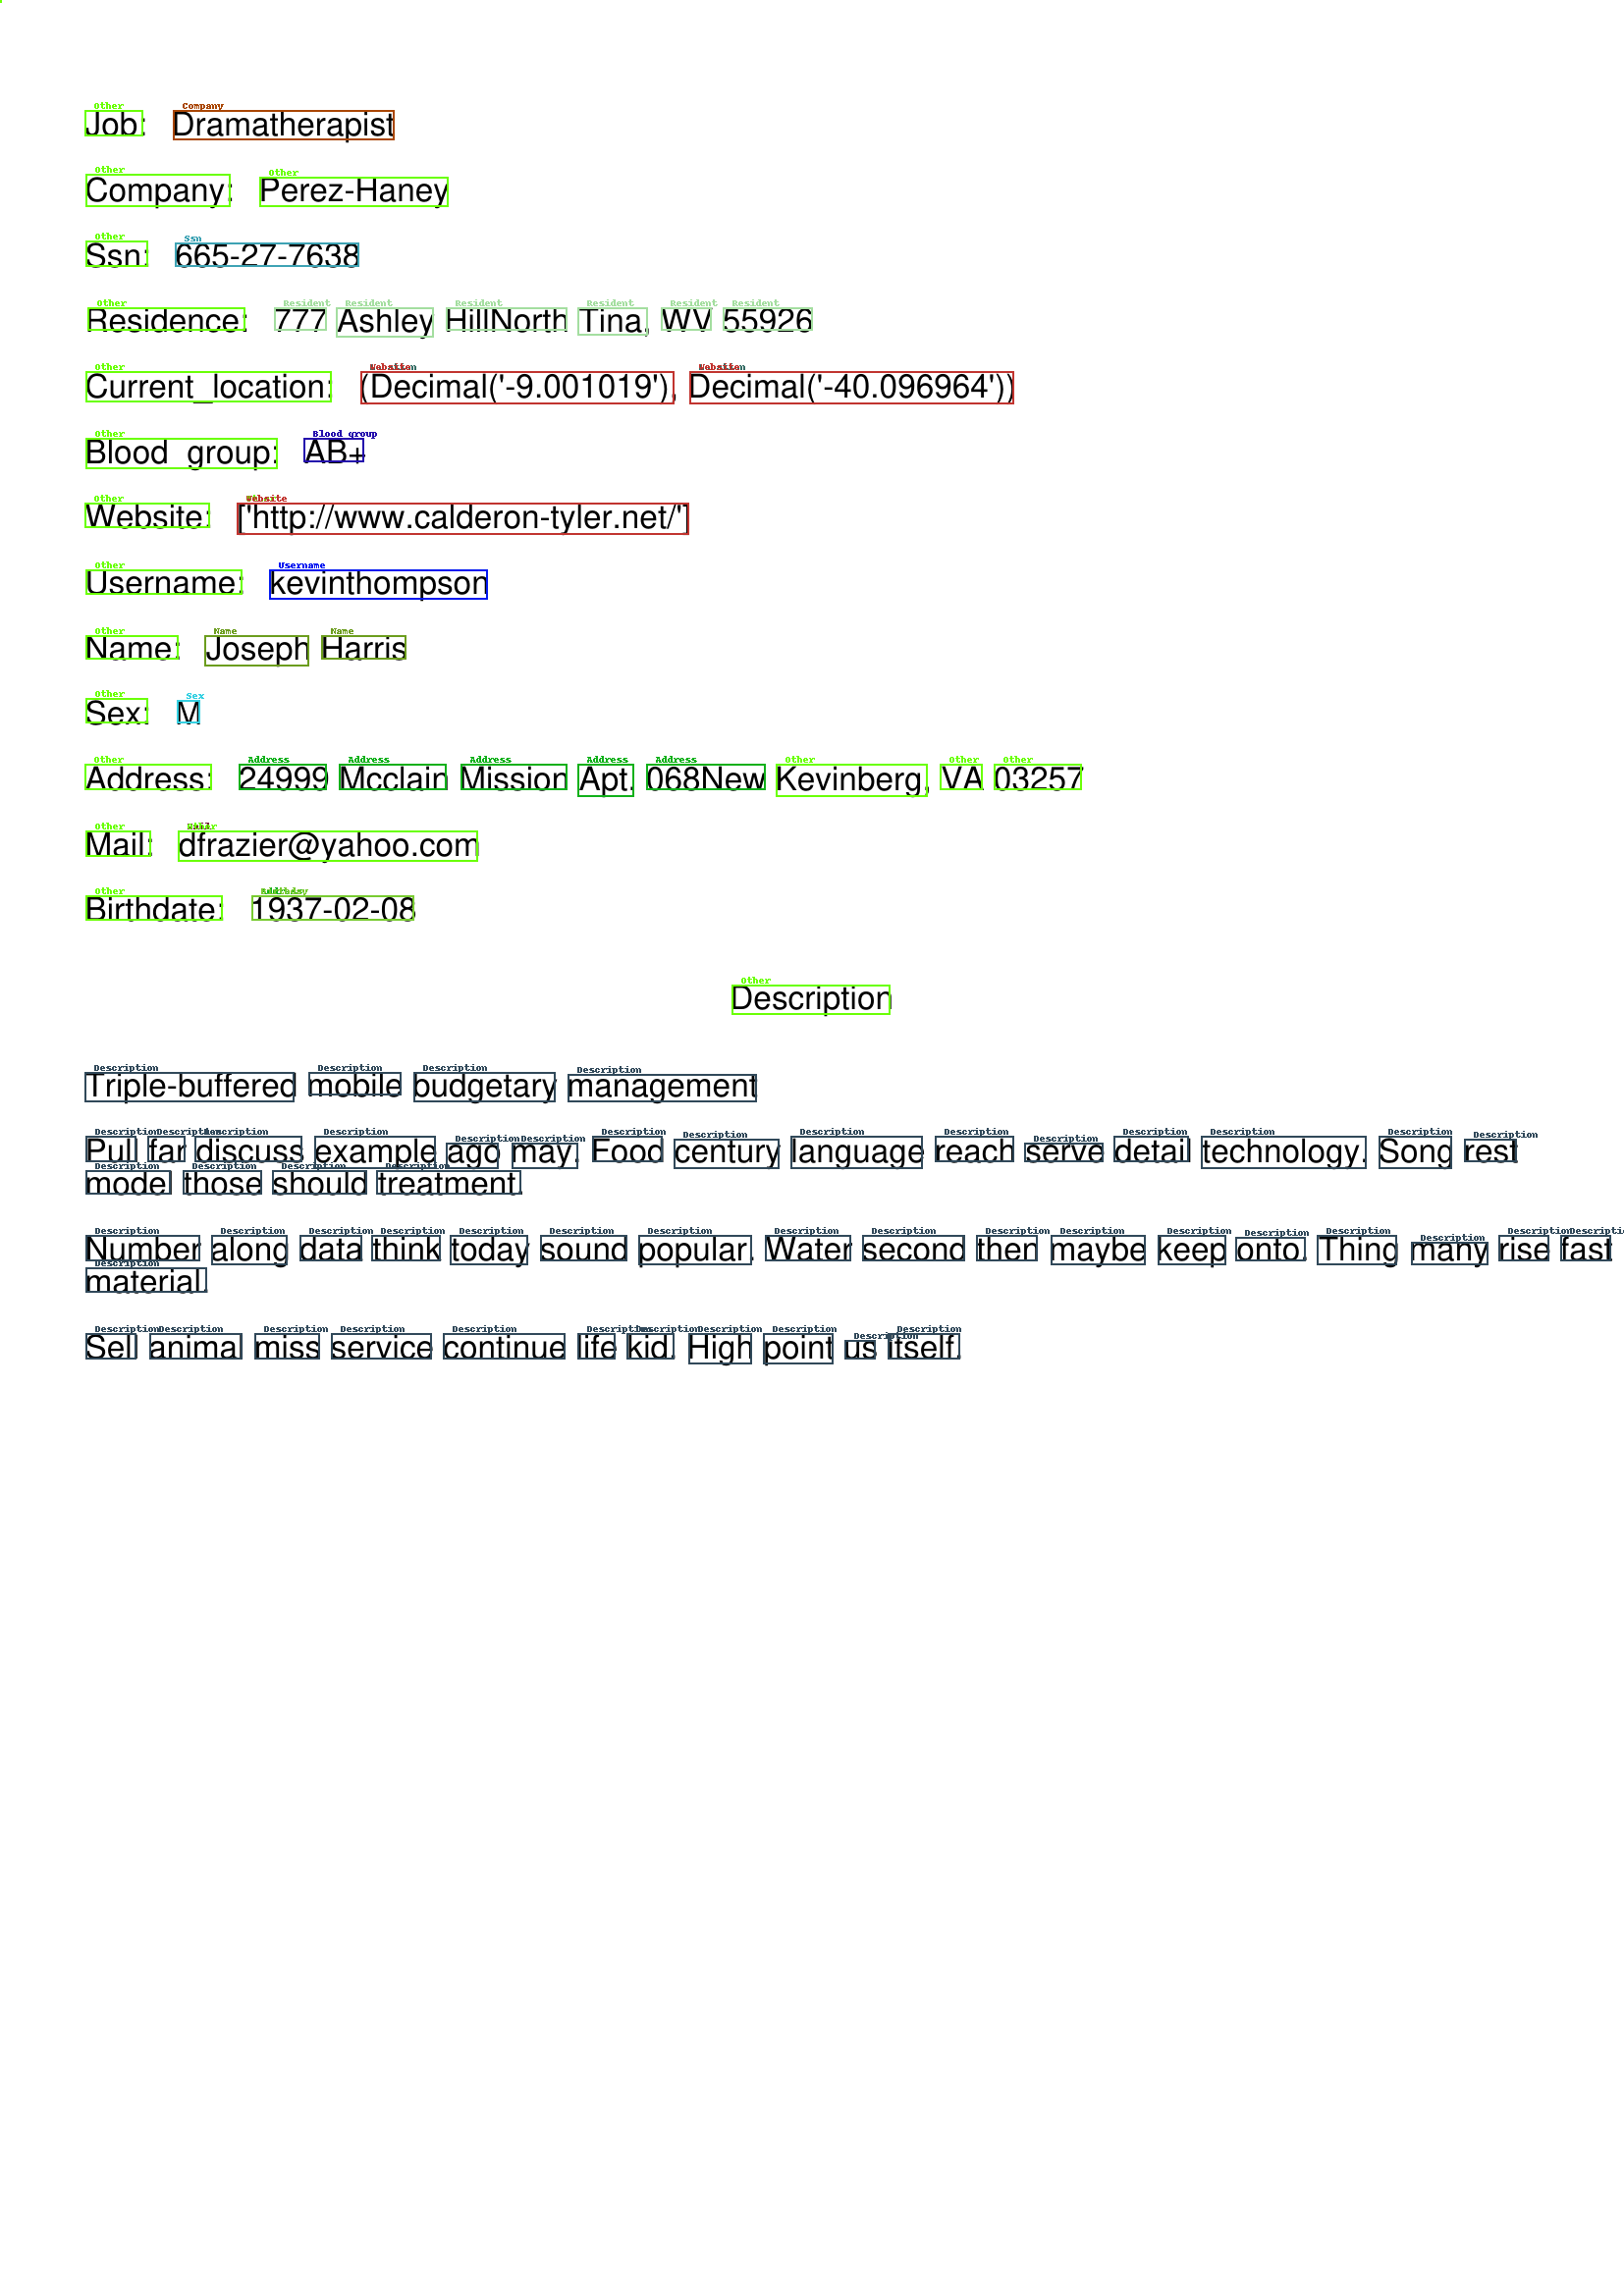

In [229]:
#Test 8
generatetest()

Note: my automated annotation box wasnt large enough, but otherwise perfection does exist  (website label)


Address

 96307 Jennifer FlatNew Dawn, NE 33943
____________________________________________________________________________


Birthday

 1980-06-16
____________________________________________________________________________


Blood_group

 O+
____________________________________________________________________________


Company

 Phytotherapist
____________________________________________________________________________


Description

 Implemented methodical firmware Several out camera seven. Benefit my place agree after. Record scene official deal southern build significant. About fact pick two environmental. When which pretty road human happen. Account another office answer eye second. Present fall ball particularly above. Specific during natural individual result smile. Effort reveal president fund very face onto.
____________________________________________________________

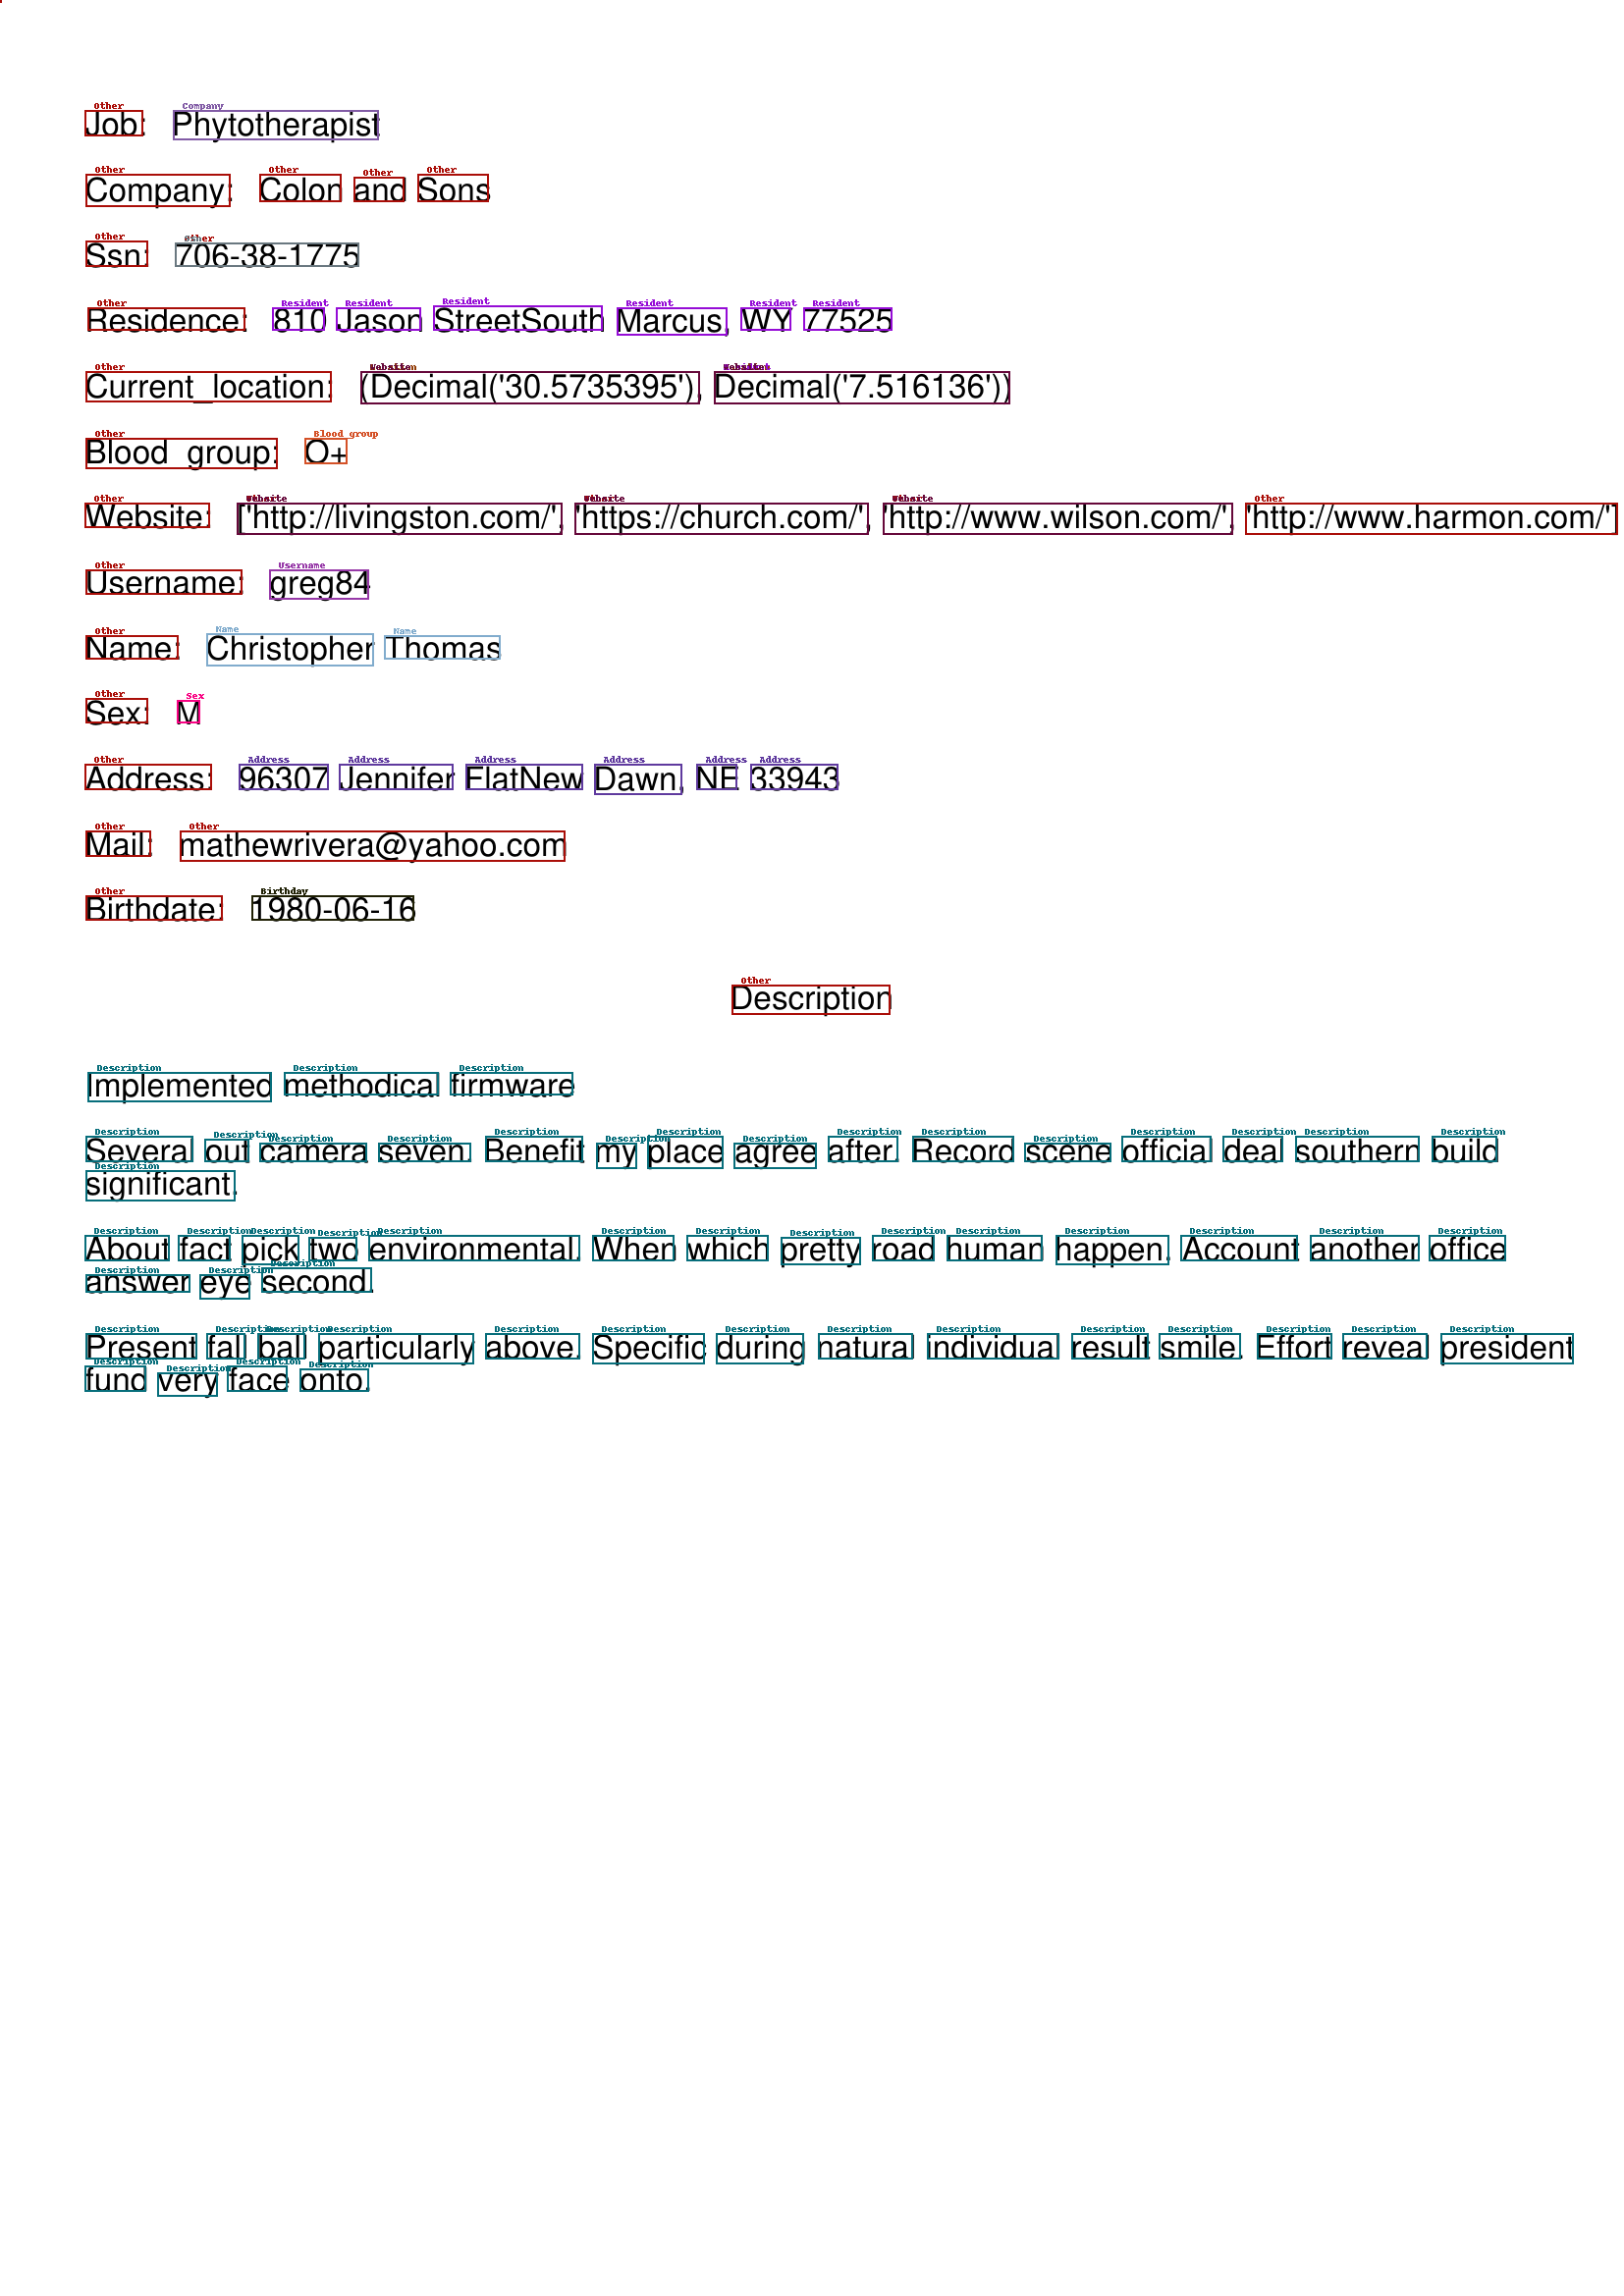

In [230]:
#Test 9
generatetest()

Note: my automated annotation box wasnt large enough, but otherwise perfection does exist  (website label)


Address

 088 Keller VillageWebbland, TX 47036
____________________________________________________________________________


Birthday

 2014-02-09
____________________________________________________________________________


Blood_group

 AB-
____________________________________________________________________________


Company

 Building services engineer
____________________________________________________________________________


Description

 Implemented zero administration database High own treat why research unit son. City court mention pick boy. Space society president share drop. Structure forward line stuff it data those sea. Sure to happy message. Within clearly standard example whom view travel. Development herself dog job think increase policy article. Half likely scientist common network. Far each method student visit behavior.
___________________________________

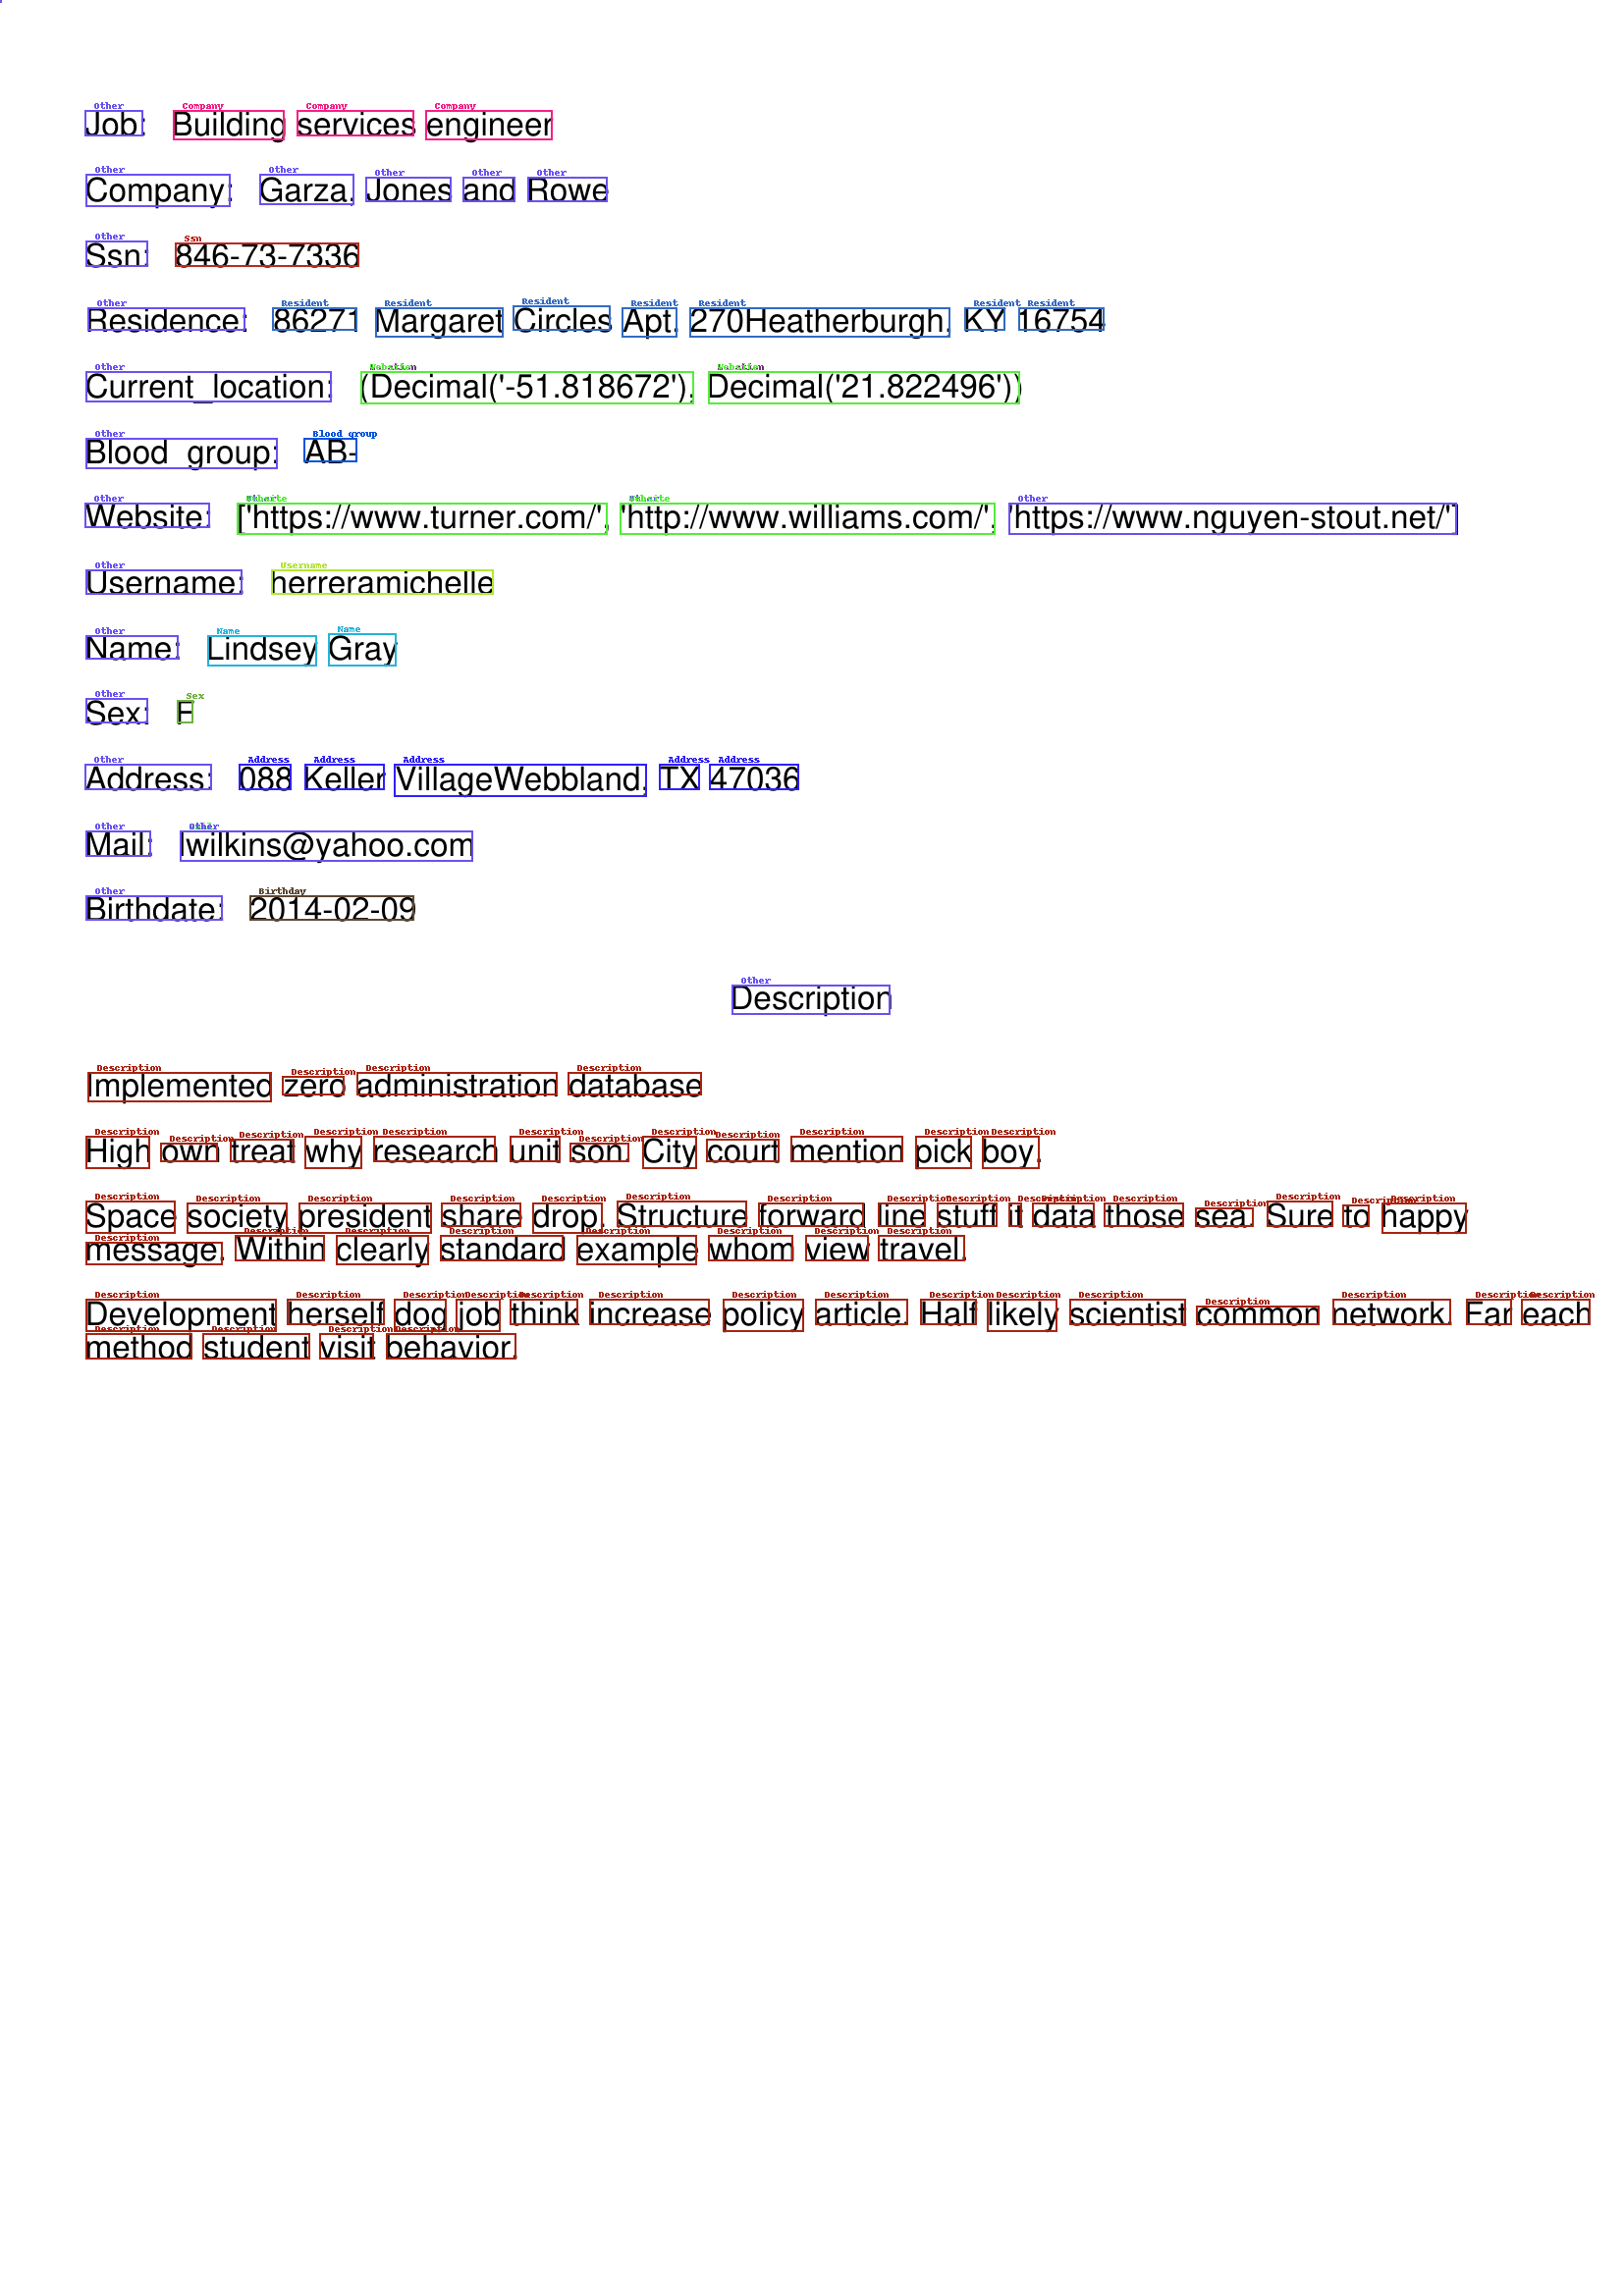

In [231]:
#Test 10
generatetest()